In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r", "human_VDss_L_kg", "human_CL_mL_min_kg"
                               ,"human_fup", "human_mrt", "human_thalf" ]]
human_inchi = human_lombardo[[ "smiles_r"]]
human_lombardo
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print(f"Transformed endpoint {endpoint} to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint human_VDss_L_kg to log base 10
Transformed endpoint human_CL_mL_min_kg to log base 10
Transformed endpoint human_mrt to log base 10
Transformed endpoint human_thalf to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [9]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  1%|▌                                        | 18/1283 [00:01<01:28, 14.24it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 20%|███████▉                               | 262/1283 [00:02<00:06, 168.93it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 22%|████████▌                              | 281/1283 [00:02<00:05, 168.93it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|██████████▉                            | 359/1283 [00:03<00:06, 148.94it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▎                          | 407/1283 [00:03<00:07, 115.20it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|█████████████████▉                     | 590/1283 [00:04<00:05, 115.72it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 48%|██████████████████▊                    | 619/1283 [00:04<00:03, 177.59it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 64%|█████████████████████████              | 824/1283 [00:05<00:01, 257.86it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|███████████████████████████            | 889/1283 [00:06<00:02, 155.26it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|██████████████████████████████▎       | 1022/1283 [00:06<00:01, 154.11it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████| 1283/1283 [00:07<00:00, 162.82it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330      2      0  43.712035  2.420516  4.841033   
1     16.484101  15.092007      1      0  24.810570  2.476291  4.952581   
2     30.181133  23.132813      4      0  49.053928  2.449016  4.898018   
3     10.077834   9.321842      0      1  17.214150  2.226811  4.453621   
4     14.384684  13.322169      0      0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166      0      1  22.084432  2.412947  4.825894   
1279  14.018917  11.675935      0      1  24.741115  2.478172  4.956344   
1280  16.038187  14.420804      0      2  27.701443  2.658726  5.024986   
1281  15.515909  12.987974      0      2  26.938755  2.326623  4.635214   
1282  11.939935   9.906091      0      2  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0     43.712035  1.248915  4.459804  ...  10.345445  71.132315  475.161514   
1     24.810570  1.127753  3.981521  ...  10.048237  56.111877  299.201654   
2     49.053928  1.257793  4.581296  ...  10.533295  89.010877  529.176450   
3     17.214150  1.229582  3.514311  ...   8.987072  44.372474  188.143376   
4     23.623048  1.243318  3.870813  ...  10.060961  67.418049  267.085521   
...         ...       ...       ...  ...        ...        ...         ...   
1278  22.084432  1.380277  3.723828  ...   9.706073  48.647579  221.128454   
1279  24.741115  1.374506  3.833767  ...   9.934065  51.418286  244.205976   
1280  27.701443  1.385072  3.997563  ...  10.245906  75.593926  263.154275   
1281  26.938755  1.346938  3.923960  ...   9.582249  66.060685  266.165174   
1282  20.559285  1.370619  3.669040  ...   9.585003  60.402256  205.097154   

           AMW  WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0     8.485027   4344    54    176.0    202.0  13.083333  7.805556  
1     6.106156   1036    34    110.0    125.0  11.180556  4.750000  
2     8.675024   5657    62    202.0    236.0  13.805556  8.611111  
3     5.879480    337    16     62.0     67.0   5.333333  3.361111  
4     8.346423    654    34    100.0    122.0   8.229167  4.291667  
...        ...    ...   ...      ...      ...        ...       ...  
1278  6.700862    412    24     84.0     99.0   3.444444  3.583333  
1279  5.550136    549    29     94.0    112.0   4.034722  4.083333  
1280  6.747546    751    30    112.0    139.0   4.256944  4.402778  
1281  6.654129    829    24    100.0    113.0   4.444444  4.527778  
1282  7.324898    359    20     80.0     94.0   3.194444  3.305556  

[1283 rows x 1613 columns]

In [11]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_smiles_r['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [12]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [13]:
Mordred_table = Mordred_table.dropna(axis='columns')
selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Mordred_table = Mordred_table [selected_Features]
# Get correlation matrix and lower triangle of pairwise correlations in long format
data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
# Get absolute sum of correlation across features
# The lower the index, the less correlation to the full data frame
# We want to drop features with highest correlation, so drop higher index
variable_cor_sum = data_cor_df.abs().sum().sort_values().index
# And subset to only variable combinations that pass the threshold
pairwise_df = pairwise_df.query("correlation > 0.95")
excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
excluded_features = list(set(excluded.tolist()))
print(len(excluded_features))
new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)

max_feature_values = new_Mordred_table.max().abs()
min_feature_values = new_Mordred_table.min().abs()

#outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
#print(len(outlier_features))
#new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
new_Mordred_table['smiles_r'] = human_smiles_r['smiles_r']
new_Mordred_table

792
440


/tmp/ipykernel_151921/1936061042.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)


nAcid  nBase  SpDiam_A     VE1_A        VR1_A     VR3_A  nBridgehead  \
0       2.0    0.0  4.841033  4.403578  1234.924831  8.371528          0.0   
1       1.0    0.0  4.952581  3.888933   315.969458  6.544103          0.0   
2       4.0    0.0  4.898018  4.662066  1678.281927  8.786502          0.0   
3       0.0    1.0  4.453621  3.435097    62.887280  4.477816          0.0   
4       0.0    0.0  4.897943  3.720015   118.815845  5.419429          0.0   
...     ...    ...       ...       ...          ...       ...          ...   
1278    0.0    1.0  4.825894  3.671875    88.167036  4.949237          0.0   
1279    0.0    1.0  4.956344  3.727444   111.594288  5.302657          0.0   
1280    0.0    2.0  5.024986  3.573443   179.009256  5.880585          0.0   
1281    0.0    2.0  4.635214  4.106193   119.951796  5.480237          0.0   
1282    0.0    2.0  4.754235  3.668878    73.788606  4.706669          0.0   

      nHetero    nH   nN  ...  TopoPSA      GGI5     GGI10  Diameter  \
0        12.0  21.0  7.0  ...   212.96  1.236111  0.276400      19.0   
1         2.0  27.0  0.0  ...    40.13  1.861111  0.000000      10.0   
2        13.0  22.0  8.0  ...   169.30  1.628333  0.295078      20.0   
3         1.0  18.0  1.0  ...     4.44  0.229167  0.000000       9.0   
4         8.0  13.0  3.0  ...   130.83  0.837222  0.000000       9.0   
...       ...   ...  ...  ...      ...       ...       ...       ...   
1278      4.0  17.0  2.0  ...    38.31  0.173611  0.000000       8.0   
1279      1.0  26.0  1.0  ...     4.44  0.291667  0.000000       8.0   
1280      2.0  19.0  2.0  ...    26.00  0.242778  0.000000       8.0   
1281      3.0  20.0  3.0  ...    29.24  0.409722  0.000000       9.0   
1282      4.0  13.0  2.0  ...    44.46  0.263889  0.000000       8.0   

          MWC10     SRW09     TSRW10   WPath   mZagreb1  \
0     12.065505  0.000000  71.132315  4344.0  13.083333   
1     11.807615  0.000000  56.111877  1036.0  11.180556   
2     12.301215  6.259581  89.010877  5657.0  13.805556   
3     10.478217  0.000000  44.372474   337.0   5.333333   
4     11.940602  7.208600  67.418049   654.0   8.229167   
...         ...       ...        ...     ...        ...   
1278  11.416536  0.000000  48.647579   412.0   3.444444   
1279  11.710045  0.000000  51.418286   549.0   4.034722   
1280  12.334901  8.464003  75.593926   751.0   4.256944   
1281  11.281510  6.259581  66.060685   829.0   4.444444   
1282  11.305397  6.293419  60.402256   359.0   3.194444   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 353 columns]

In [14]:
Mordred_columns = new_Mordred_table.columns[:-1].tolist()

#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mordred_columns = Mordred_columns 
print(len(features_mordred_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mordred_columns_human.txt", "w")
for item in features_mordred_columns:
   f.write(item + "\n")
f.close()

352


In [15]:
#read from file
file = open("features_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mordred_columns = file_lines.split("\n")
features_mordred_columns = features_mordred_columns[:-1]
features_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR1_A',
 'VR3_A',
 'nBridgehead',
 'nHetero',
 'nH',
 'nN',
 'nO',
 'nS',
 'nP',
 'nF',
 'nX',
 'ATS0dv',
 'ATS4dv',
 'ATS2s',
 'ATS4s',
 'ATS4m',
 'ATS5i',
 'ATS8i',
 'AATS1dv',
 'AATS2dv',
 'AATS3dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS0s',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS1m',
 'AATS3m',
 'AATS1v',
 'AATS3v',
 'AATS1are',
 'AATS2are',
 'AATS3are',
 'AATS0p',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC2Z',
 'ATSC5Z',
 'ATSC6Z',
 'ATSC0m',
 'ATSC3m',
 'ATSC4m',
 'ATSC7m',
 'ATSC8m',
 'ATSC1v',
 'ATSC2v',
 'ATSC3v',
 'ATSC4v',
 'ATSC5v',
 'ATSC6v',
 

In [16]:
human_lombardo_Mordred = pd.merge(human_lombardo, new_Mordred_table)
human_lombardo_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  nAcid  nBase  \
0               0.638489       0.33   0.568202     1.176091    2.0    0.0   
1               0.949390        NaN   1.348305     1.705008    1.0    0.0   
2              -0.537602       0.01   1.482588     1.894870    4.0    0.0   
3               1.301030       0.13   0.204120     0.113943    0.0    1.0   
4               0.204120        NaN   1.068186     1.037426    0.0    0.0   
...                  ...        ...        ...          ...    ...    ...   
1278            0.903090        NaN   1.021189     0.913814    0.0    1.0   
1279            0.707570       0.35   1.361728     1.204120    0.0    1.0   
1280            0.934498       0.50   0.892095     0.863323    0.0    2.0   
1281            1.293804        NaN   0.537819     0.359835    0.0    2.0   
1282            1.000000        NaN   0.740363     0.623249    0.0    2.0   

      SpDiam_A     VE1_A  ...    SLogP  TopoPSA      GGI5     GGI10  Diameter  \
0     4.841033  4.403578  ... -1.68780   212.96  1.236111  0.276400      19.0   
1     4.952581  3.888933  ...  4.34140    40.13  1.861111  0.000000      10.0   
2     4.898018  4.662066  ... -0.42876   169.30  1.628333  0.295078      20.0   
3     4.453621  3.435097  ...  0.76550     4.44  0.229167  0.000000       9.0   
4     4.897943  3.720015  ... -2.55960   130.83  0.837222  0.000000       9.0   
...        ...       ...  ...      ...      ...       ...       ...       ...   
1278  4.825894  3.671875  ... -0.15880    38.31  0.173611  0.000000       8.0   
1279  4.956344  3.727444  ...  2.91480     4.44  0.291667  0.000000       8.0   
1280  5.024986  3.573443  ...  1.07490    26.00  0.242778  0.000000       8.0   
1281  4.635214  4.106193  ...  0.77550    29.24  0.409722  0.000000       9.0   
1282  4.754235  3.668878  ... -1.09130    44.46  0.263889  0.000000       8.0   

          MWC10     SRW09     TSRW10   WPath   mZagreb1  
0     12.065505  0.000000  71.132315  4344.0  13.083333  
1     11.807615  0.000000  56.111877  1036.0  11.180556  
2     12.301215  6.259581  89.010877  5657.0  13.805556  
3     10.478217  0.000000  44.372474   337.0   5.333333  
4     11.940602  7.208600  67.418049   654.0   8.229167  
...         ...       ...        ...     ...        ...  
1278  11.416536  0.000000  48.647579   412.0   3.444444  
1279  11.710045  0.000000  51.418286   549.0   4.034722  
1280  12.334901  8.464003  75.593926   751.0   4.256944  
1281  11.281510  6.259581  66.060685   829.0   4.444444  
1282  11.305397  6.293419  60.402256   359.0   3.194444  

[1283 rows x 358 columns]

human_VDss_L_kg
0
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  54.800000000000004
3-fold :  74.4
5-fold :  87.2
gmfe :  2.1917328512127177
mfe :  1.2992033852971785
bias :  0.027853696917957152
rmse  0.4545873906358373
r2  0.5210524247902324
saving model


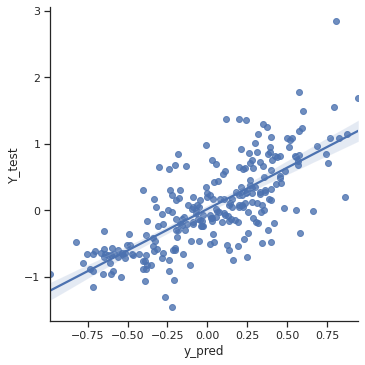

1
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
250
2-fold :  56.8
3-fold :  74.0
5-fold :  88.4
gmfe :  2.1133030715377172
mfe :  1.2820351025629655
bias :  0.10224329813403776
rmse  0.42320924557054673
r2  0.5202641626746067
saving model


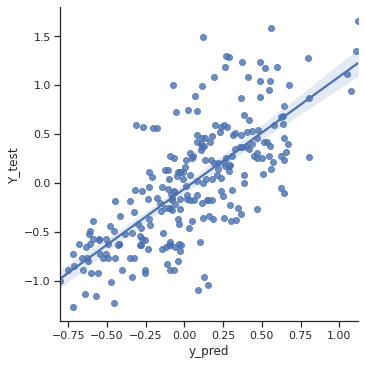

2
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  56.8
3-fold :  74.0
5-fold :  85.6
gmfe :  2.2253920683513777
mfe :  1.2833447801083826
bias :  0.001303059298825432
rmse  0.47891280670515063
r2  0.4719841267951268


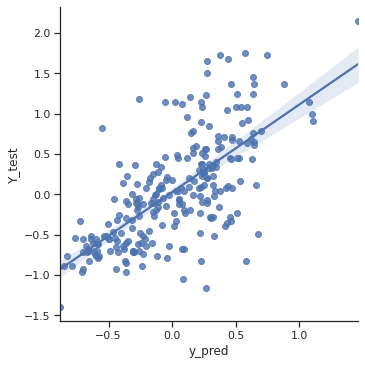

3
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
250
2-fold :  58.4
3-fold :  73.6
5-fold :  88.8
gmfe :  2.1320327903626675
mfe :  1.2995921489469835
bias :  0.004299120830643877
rmse  0.4329334753762373
r2  0.5524573419733401


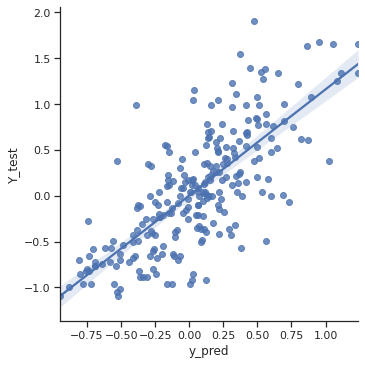

4
(1000, 352)
(249, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
249
2-fold :  53.81526104417671
3-fold :  72.69076305220884
5-fold :  88.75502008032129
gmfe :  2.211027371870432
mfe :  1.2980154678166542
bias :  0.07027766317778816
rmse  0.4546666122987726
r2  0.46420792016995527


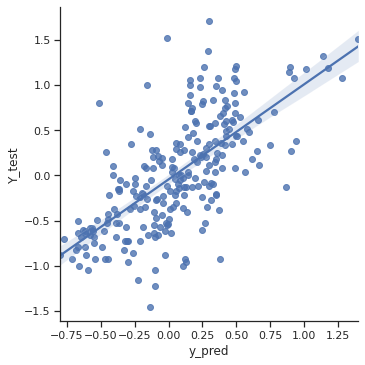

0
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  57.199999999999996
3-fold :  72.8
5-fold :  89.2
gmfe :  2.142237906065543
mfe :  1.2885532393751582
bias :  0.05906535797869772
rmse  0.43043871958101393
r2  0.49278124154737424


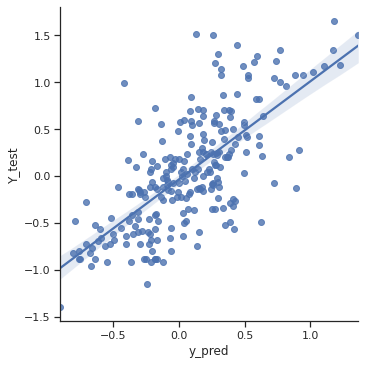

1
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  52.0
3-fold :  71.2
5-fold :  86.0
gmfe :  2.293531115974898
mfe :  1.3308833529414084
bias :  0.04541759061678301
rmse  0.47230964302150463
r2  0.514935715973541


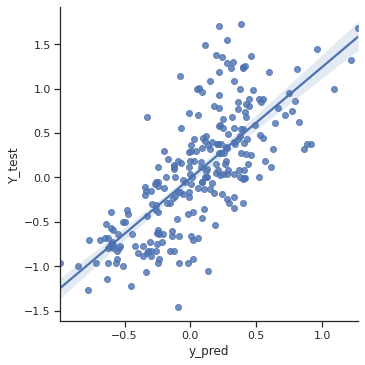

2
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=43)
250
2-fold :  57.199999999999996
3-fold :  77.2
5-fold :  88.8
gmfe :  2.138632030051383
mfe :  1.2768110633281147
bias :  0.022681225865749888
rmse  0.4461011105723518
r2  0.49328877640446445


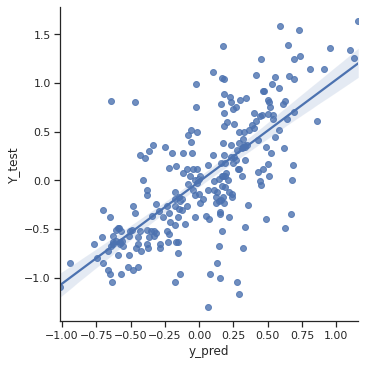

3
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
250
2-fold :  59.599999999999994
3-fold :  76.8
5-fold :  90.0
gmfe :  2.077193917030531
mfe :  1.2814997089622786
bias :  -0.002149555281309487
rmse  0.43772940643178043
r2  0.5276612983845961
saving model


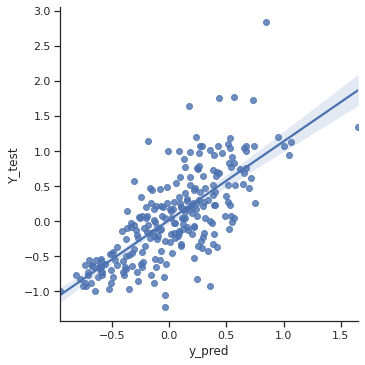

4
(1000, 352)
(249, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  55.82329317269076
3-fold :  72.28915662650603
5-fold :  89.95983935742971
gmfe :  2.1524591623099005
mfe :  1.301948311627396
bias :  0.030260845860173413
rmse  0.4404512955111916
r2  0.5389892889820047


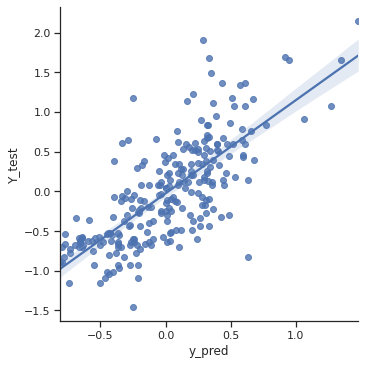

0
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  54.800000000000004
3-fold :  72.8
5-fold :  86.0
gmfe :  2.207014206698268
mfe :  1.298768817564557
bias :  0.017689429816213353
rmse  0.4637249020212942
r2  0.4745940613827587


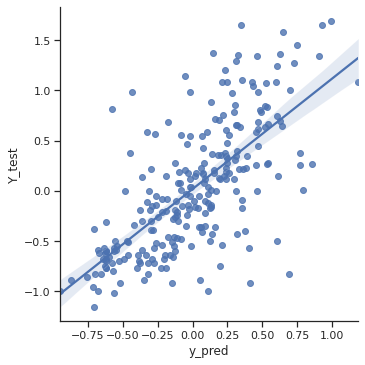

1
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  55.2
3-fold :  74.8
5-fold :  88.4
gmfe :  2.2254843303587637
mfe :  1.3005191419580342
bias :  0.04359079658178272
rmse  0.45572255963390124
r2  0.5416920226441706


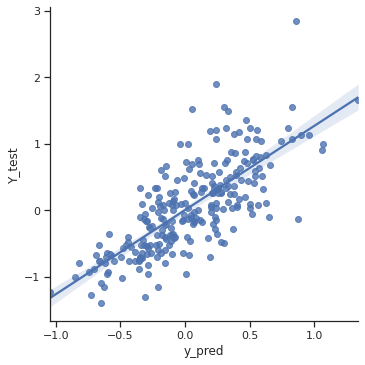

2
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  56.00000000000001
3-fold :  68.8
5-fold :  88.4
gmfe :  2.2176765059840093
mfe :  1.2840164896501132
bias :  0.06591445446439537
rmse  0.44922509820428613
r2  0.5170182390812079


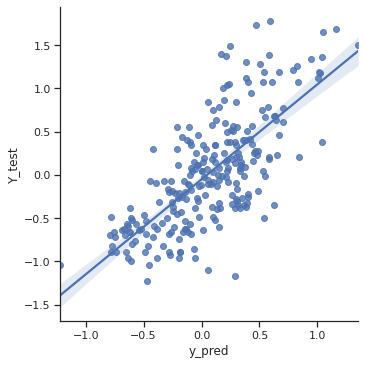

3
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  60.0
3-fold :  74.8
5-fold :  90.0
gmfe :  2.105881367869873
mfe :  1.3015841049089127
bias :  0.06237496212570026
rmse  0.42452446456086
r2  0.5052187637598546


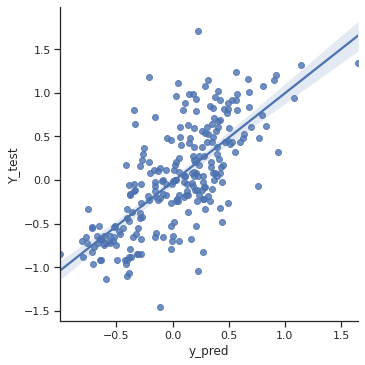

4
(1000, 352)
(249, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
249
2-fold :  61.044176706827315
3-fold :  80.32128514056225
5-fold :  89.95983935742971
gmfe :  2.048122406843902
mfe :  1.2558629308188123
bias :  -0.008482241733861362
rmse  0.4177249684749289
r2  0.5654815637927995
saving model


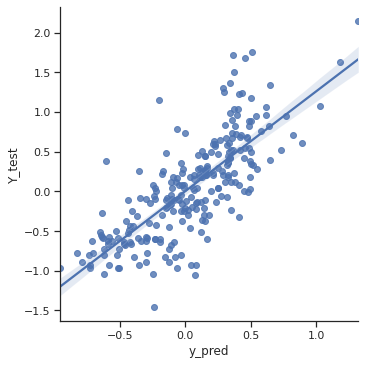

0
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
250
2-fold :  58.8
3-fold :  73.6
5-fold :  88.8
gmfe :  2.1730286320149306
mfe :  1.2808120544823205
bias :  -0.015546515144011772
rmse  0.4631892703088865
r2  0.4815839819588501


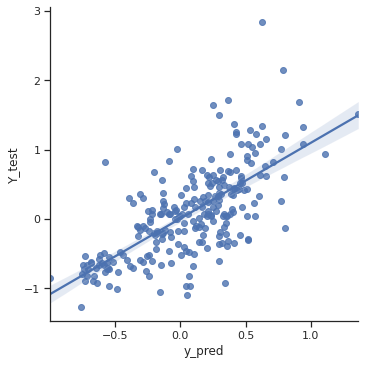

1
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
250
2-fold :  56.39999999999999
3-fold :  76.4
5-fold :  88.0
gmfe :  2.110351266143454
mfe :  1.2754926658637542
bias :  0.029257681822177
rmse  0.4292266813937965
r2  0.477912135161349


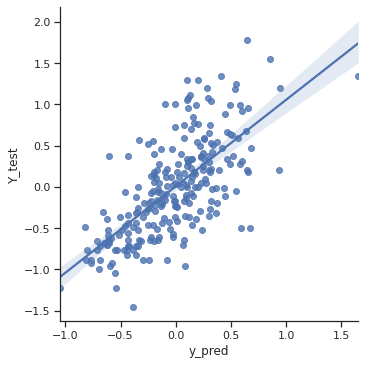

2
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  56.39999999999999
3-fold :  71.6
5-fold :  87.6
gmfe :  2.290690625376855
mfe :  1.2992870942785024
bias :  0.016732735755315642
rmse  0.48096944411063647
r2  0.4934401475967807


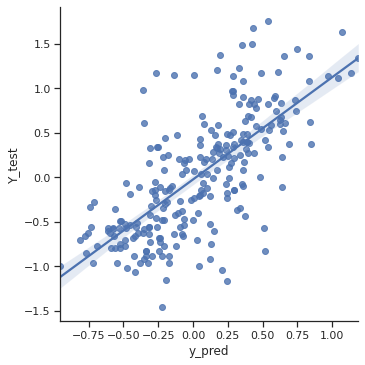

3
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  53.6
3-fold :  73.2
5-fold :  87.2
gmfe :  2.1990998821222614
mfe :  1.3225049093551768
bias :  0.13071426062691527
rmse  0.44119167424222133
r2  0.5060907599449482


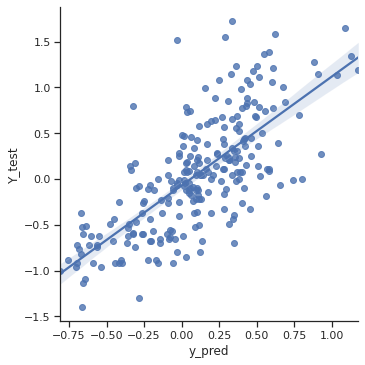

4
(1000, 352)
(249, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
249
2-fold :  57.42971887550201
3-fold :  75.1004016064257
5-fold :  90.76305220883533
gmfe :  2.0630251850699817
mfe :  1.2743849700669285
bias :  0.051260783362532536
rmse  0.41059977636216394
r2  0.6018324639959601


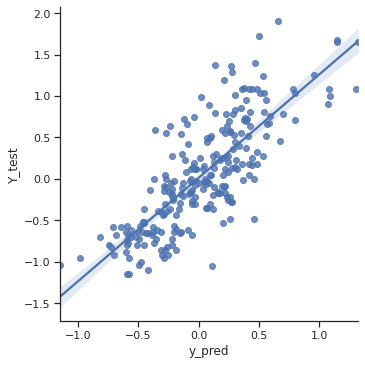

0
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
250
2-fold :  53.6
3-fold :  74.8
5-fold :  88.8
gmfe :  2.1789035010249713
mfe :  1.3157816686786834
bias :  0.017844813721854383
rmse  0.4437169396620752
r2  0.49559500966200454


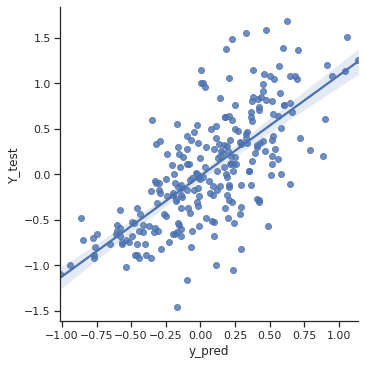

1
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
250
2-fold :  57.199999999999996
3-fold :  74.8
5-fold :  90.4
gmfe :  2.1437515349914515
mfe :  1.2883694507724117
bias :  0.09511951073041577
rmse  0.44222795724537606
r2  0.5382049960808541


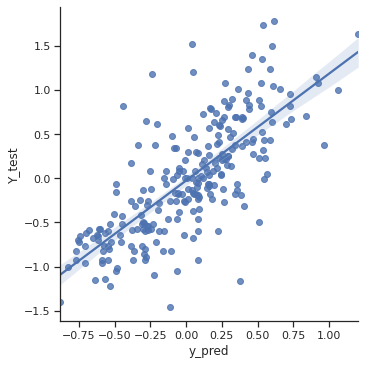

2
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
250
2-fold :  59.599999999999994
3-fold :  76.0
5-fold :  89.60000000000001
gmfe :  2.0835609660500527
mfe :  1.2419969289311725
bias :  0.01818057193404185
rmse  0.43212686907311176
r2  0.5396642337463399


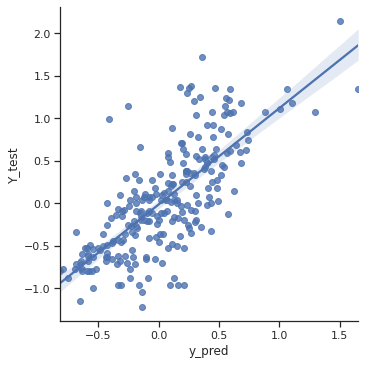

3
(999, 352)
(250, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  54.400000000000006
3-fold :  72.8
5-fold :  90.4
gmfe :  2.1757620274974077
mfe :  1.3053465394017385
bias :  -0.010764744709748919
rmse  0.4340998814164553
r2  0.5557141774843541


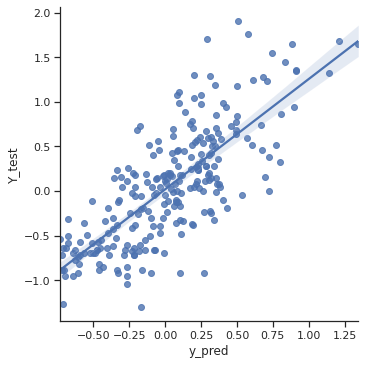

4
(1000, 352)
(249, 352)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
249
2-fold :  55.82329317269076
3-fold :  73.89558232931726
5-fold :  88.35341365461848
gmfe :  2.1903872184151605
mfe :  1.2901032754520798
bias :  0.0637196184854375
rmse  0.4531835015495399
r2  0.4877402115416378


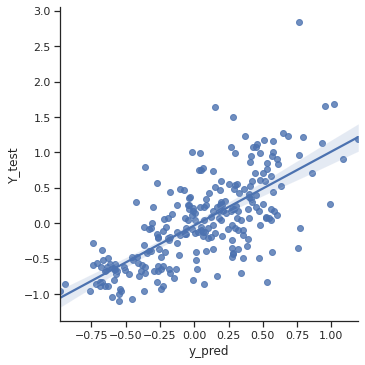

human_CL_mL_min_kg
0
(1024, 352)
(257, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
257
2-fold :  49.80544747081712
3-fold :  70.8171206225681
5-fold :  83.26848249027238
gmfe :  2.580030200816012
mfe :  1.3520653556962958
bias :  0.0625204739706966
rmse  0.5780342987523177
r2  0.2673653984846245
saving model


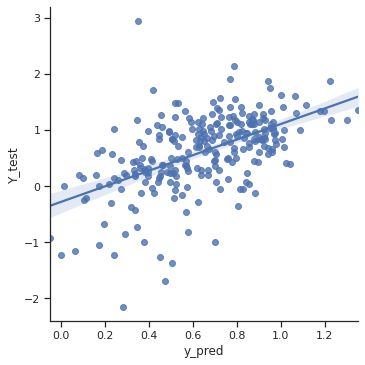

1
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
256
2-fold :  48.4375
3-fold :  72.265625
5-fold :  84.765625
gmfe :  2.458651827293283
mfe :  1.3587346433689247
bias :  -0.31811432712244336
rmse  0.528724616826929
r2  0.3118645582597688
saving model


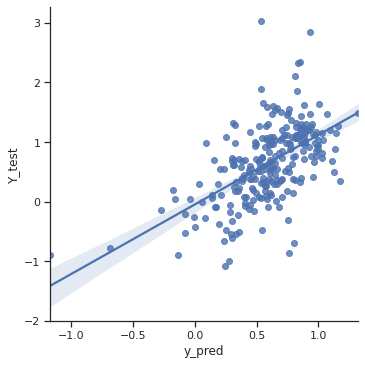

2
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  53.90625
3-fold :  71.875
5-fold :  84.765625
gmfe :  2.454033113513651
mfe :  1.3311631799843555
bias :  -0.46087401352126334
rmse  0.521651533497685
r2  0.24608486336679702
saving model


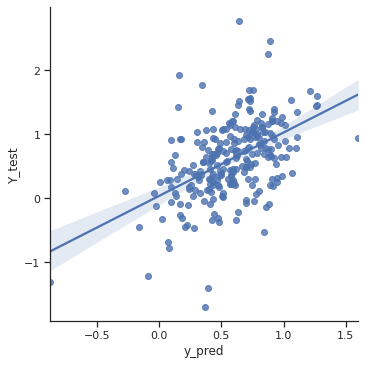

3
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
256
2-fold :  50.390625
3-fold :  66.796875
5-fold :  86.328125
gmfe :  2.494688745059509
mfe :  1.343997776266706
bias :  -0.7110974981595651
rmse  0.5343485991740572
r2  0.3400486050314169


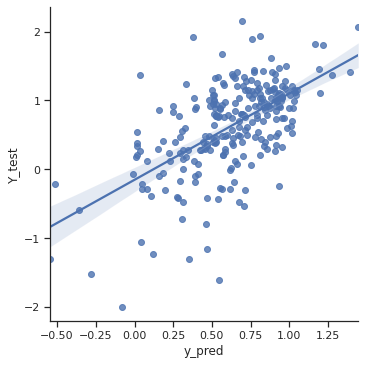

4
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  49.21875
3-fold :  67.578125
5-fold :  81.640625
gmfe :  2.6963230357684296
mfe :  1.3755749931111867
bias :  0.10498372832333136
rmse  0.6037526367349891
r2  0.1856784815748822


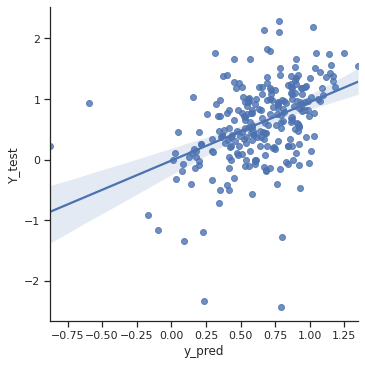

0
(1024, 352)
(257, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
257
2-fold :  50.19455252918288
3-fold :  64.59143968871595
5-fold :  81.71206225680933
gmfe :  2.6695443711520848
mfe :  1.3504313637534595
bias :  0.022308084595338507
rmse  0.6133449899166818
r2  0.2579344261346912


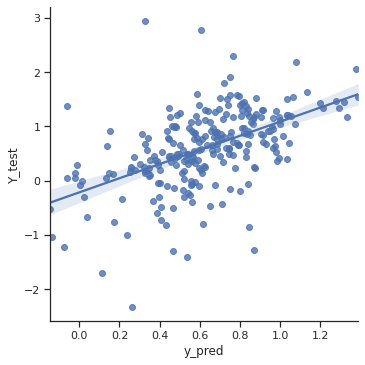

1
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
256
2-fold :  42.1875
3-fold :  64.84375
5-fold :  80.859375
gmfe :  2.869451312300175
mfe :  1.433476345562868
bias :  -0.2511556644534959
rmse  0.6121556345678691
r2  0.25121263877677147


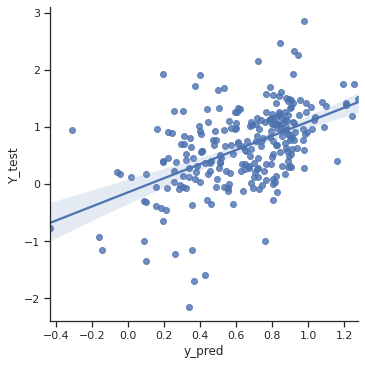

2
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
256
2-fold :  46.09375
3-fold :  69.921875
5-fold :  85.15625
gmfe :  2.4646995663055806
mfe :  1.396756854336555
bias :  -0.4701458630979045
rmse  0.5128452178542742
r2  0.272152606406472


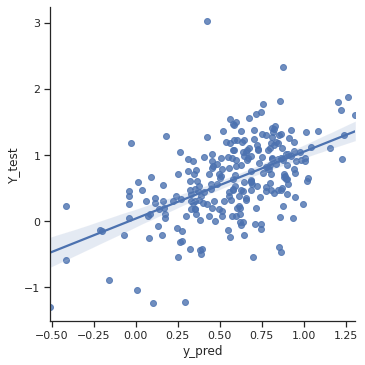

3
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
256
2-fold :  51.953125
3-fold :  75.0
5-fold :  87.5
gmfe :  2.3527222622901656
mfe :  1.3173216012220645
bias :  -0.2781161056051884
rmse  0.49834860031588335
r2  0.3183578646224513
saving model


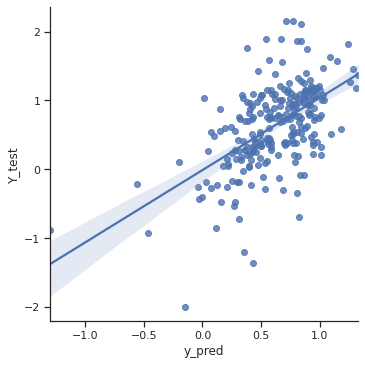

4
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
256
2-fold :  55.078125
3-fold :  70.3125
5-fold :  85.546875
gmfe :  2.304733545771155
mfe :  1.3026083773407855
bias :  -0.08868912960937142
rmse  0.5007847513829632
r2  0.3221507235200288
saving model


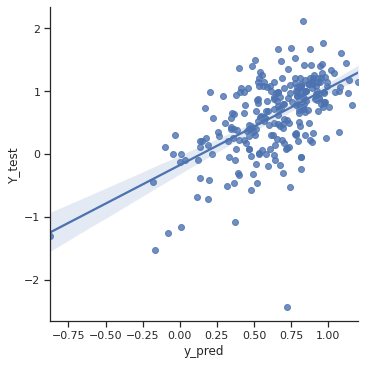

0
(1024, 352)
(257, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
257
2-fold :  49.416342412451364
3-fold :  71.59533073929961
5-fold :  87.15953307392996
gmfe :  2.3822355926035055
mfe :  1.3528029239218
bias :  -0.42777518173061435
rmse  0.5111539222720146
r2  0.3536718979071982


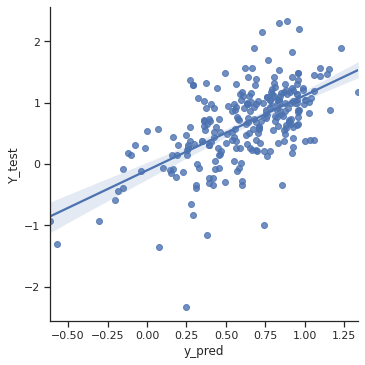

1
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  52.734375
3-fold :  73.046875
5-fold :  87.109375
gmfe :  2.4162006017494306
mfe :  1.3176473638828727
bias :  -0.49680616359900776
rmse  0.5299847874661032
r2  0.2877645972923589


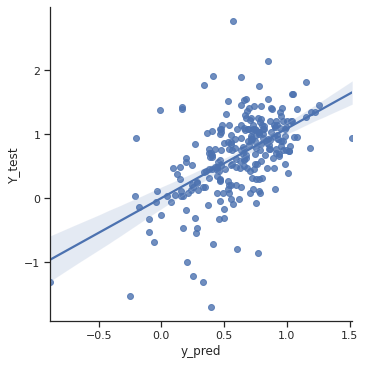

2
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
256
2-fold :  52.734375
3-fold :  69.53125
5-fold :  82.03125
gmfe :  2.5606634144411444
mfe :  1.3256424630500996
bias :  0.45579070551122935
rmse  0.562773041002071
r2  0.2997852280620702


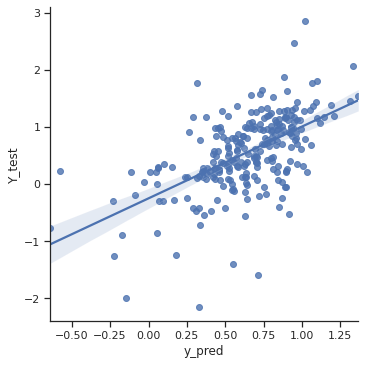

3
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  46.484375
3-fold :  67.1875
5-fold :  84.375
gmfe :  2.70385963940395
mfe :  1.3780299288720186
bias :  -0.0910141670541938
rmse  0.5994697528551685
r2  0.21496004753483033


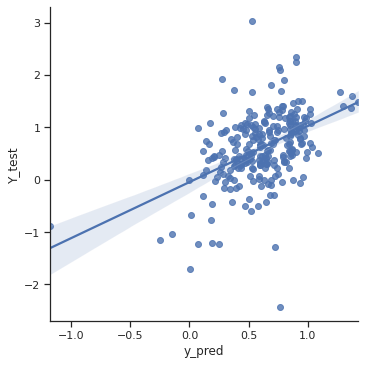

4
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  49.21875
3-fold :  67.96875
5-fold :  84.765625
gmfe :  2.4656273571675134
mfe :  1.3589745650539558
bias :  -0.33192995726217767
rmse  0.5285689513555388
r2  0.2801238605568245


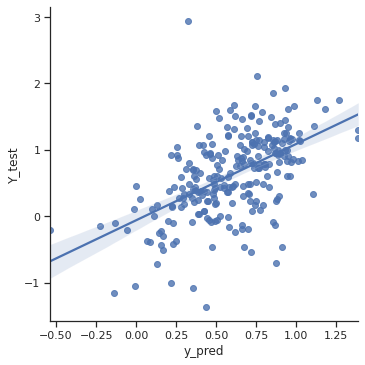

0
(1024, 352)
(257, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
257
2-fold :  46.69260700389105
3-fold :  69.64980544747081
5-fold :  87.54863813229572
gmfe :  2.399016299874876
mfe :  1.3774948326801295
bias :  -0.7958652448967212
rmse  0.4745460922349794
r2  0.32389734812134263


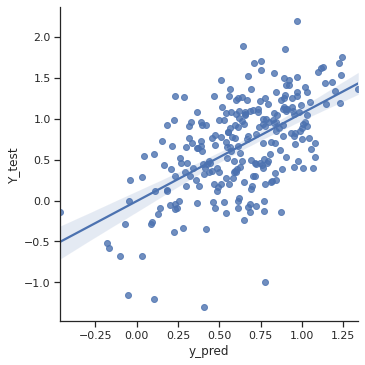

1
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=45)
256
2-fold :  48.828125
3-fold :  67.96875
5-fold :  83.203125
gmfe :  2.4745886123687946
mfe :  1.3687935757667093
bias :  0.14017617831076734
rmse  0.5091779096402446
r2  0.3050131820567912


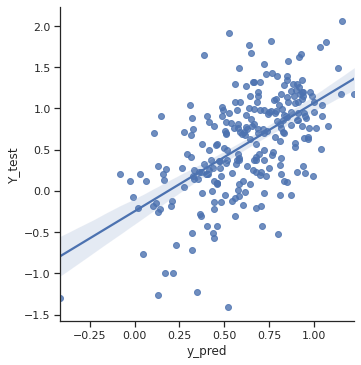

2
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  50.0
3-fold :  69.53125
5-fold :  84.375
gmfe :  2.590274469104926
mfe :  1.3534833033211053
bias :  -0.806066313421056
rmse  0.583213165933965
r2  0.2350826219937282


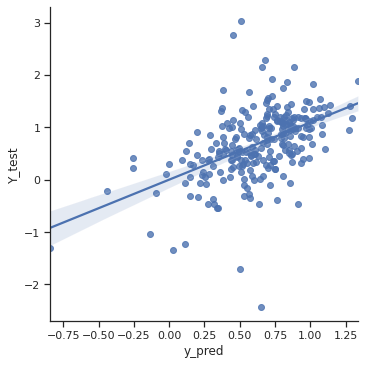

3
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  53.515625
3-fold :  71.875
5-fold :  83.984375
gmfe :  2.480151428722132
mfe :  1.3166413373796801
bias :  -0.1842841925808567
rmse  0.5560708226547278
r2  0.2453059015983251


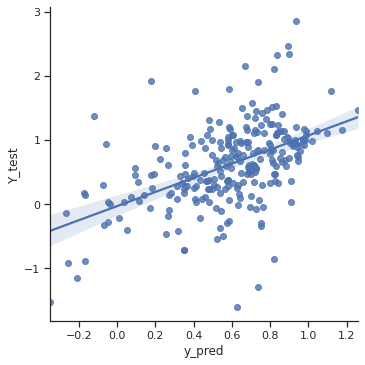

4
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
256
2-fold :  49.609375
3-fold :  67.578125
5-fold :  82.03125
gmfe :  2.687641631156754
mfe :  1.3609017240516728
bias :  -0.2505340111189872
rmse  0.6115211340096912
r2  0.297767182685335


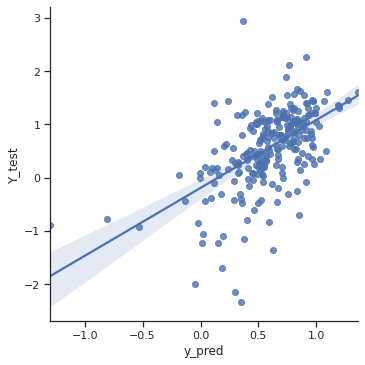

0
(1024, 352)
(257, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
257
2-fold :  49.80544747081712
3-fold :  68.09338521400778
5-fold :  84.8249027237354
gmfe :  2.4950930670562594
mfe :  1.3513973638158936
bias :  -0.6422443991251992
rmse  0.5559594759992946
r2  0.232464443993471


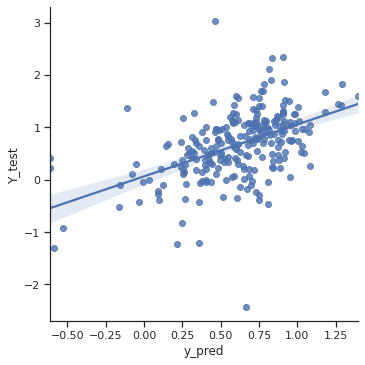

1
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
256
2-fold :  46.09375
3-fold :  64.0625
5-fold :  80.46875
gmfe :  2.8043595418294966
mfe :  1.3905992751780574
bias :  -0.2987940002075784
rmse  0.6063859620613179
r2  0.28310263897514487


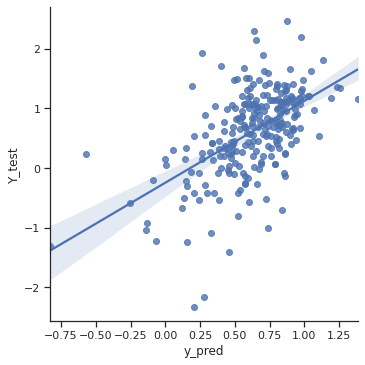

2
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
256
2-fold :  52.34375
3-fold :  70.3125
5-fold :  81.25
gmfe :  2.54569501476575
mfe :  1.3197651266242583
bias :  0.1098668677482868
rmse  0.5767712901548041
r2  0.24284235965815004


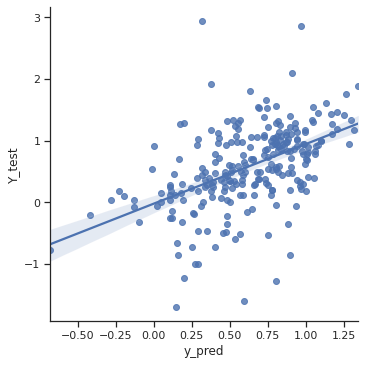

3
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
256
2-fold :  44.921875
3-fold :  66.796875
5-fold :  83.984375
gmfe :  2.5509190809632076
mfe :  1.3746809118916115
bias :  -0.1646990105847127
rmse  0.5375815618199555
r2  0.30740727094555864


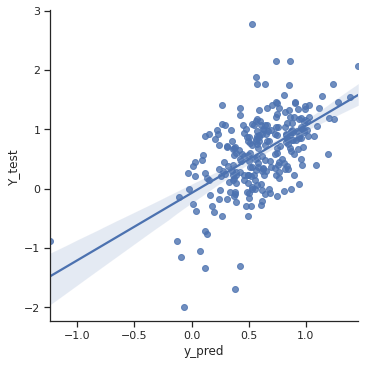

4
(1025, 352)
(256, 352)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
256
2-fold :  50.78125
3-fold :  73.828125
5-fold :  88.671875
gmfe :  2.28892776027928
mfe :  1.347014946574577
bias :  -0.4301385933427012
rmse  0.4687096382765798
r2  0.32985368345771693
saving model


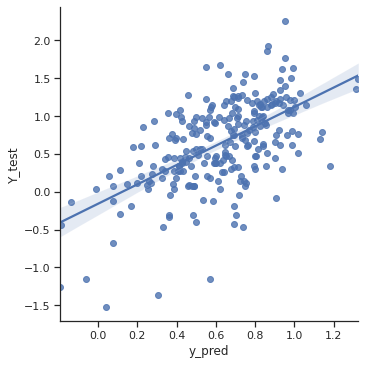

human_fup
0
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
176
2-fold :  52.84090909090909
3-fold :  61.36363636363637
5-fold :  72.72727272727273
gmfe :  3.253483949879044
mfe :  1.3055938427139393
bias :  0.06354986787463823
rmse  0.21553984758384329
r2  0.6234968305840107
saving model


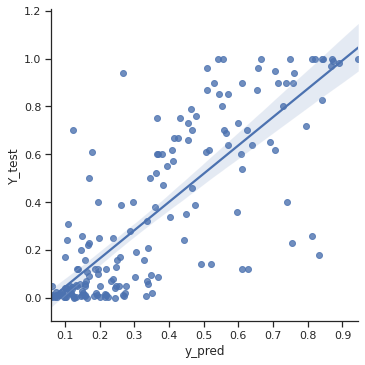

1
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
176
2-fold :  52.84090909090909
3-fold :  69.88636363636364
5-fold :  78.97727272727273
gmfe :  2.8508799951343815
mfe :  1.316718368955276
bias :  0.05853290165641456
rmse  0.20648217851042266
r2  0.579227099721478
saving model


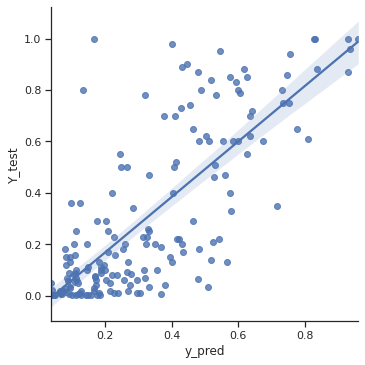

2
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
176
2-fold :  56.25
3-fold :  70.45454545454545
5-fold :  82.38636363636364
gmfe :  2.6185700094381974
mfe :  1.263287449092704
bias :  -0.01282630852070303
rmse  0.24214008476402724
r2  0.5120102899706531
saving model


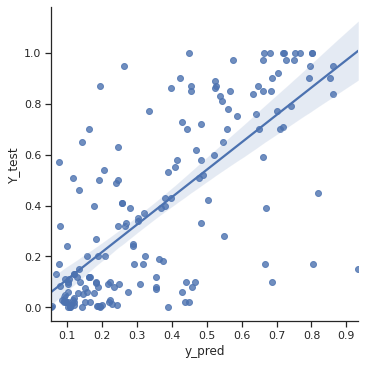

3
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
176
2-fold :  49.43181818181818
3-fold :  64.77272727272727
5-fold :  77.27272727272727
gmfe :  2.84479670698375
mfe :  1.357904697120073
bias :  0.04804058861643179
rmse  0.22594617618681606
r2  0.574308327427641


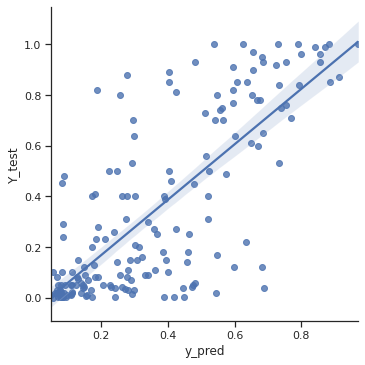

4
(704, 352)
(175, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
175
2-fold :  55.42857142857143
3-fold :  67.42857142857143
5-fold :  75.42857142857143
gmfe :  2.7976964939260207
mfe :  1.304059732119493
bias :  0.04754107667650921
rmse  0.2078481910663718
r2  0.617079391127946


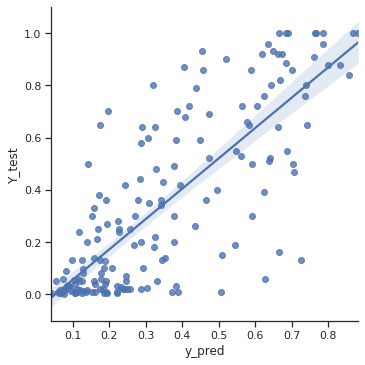

0
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  53.40909090909091
3-fold :  65.3409090909091
5-fold :  78.4090909090909
gmfe :  2.7458241592535613
mfe :  1.2997169950862617
bias :  0.04954971254888518
rmse  0.22773445606106
r2  0.5482157281816216


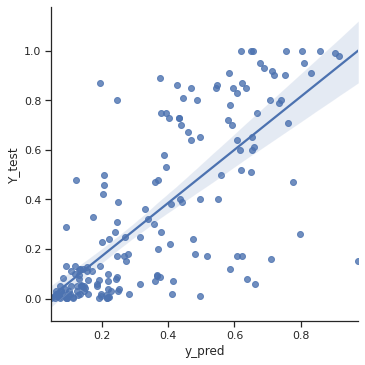

1
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
176
2-fold :  58.52272727272727
3-fold :  64.20454545454545
5-fold :  77.27272727272727
gmfe :  2.8307298851825635
mfe :  1.2626275370909503
bias :  0.032281560209142274
rmse  0.2056823183768671
r2  0.5899903218150061


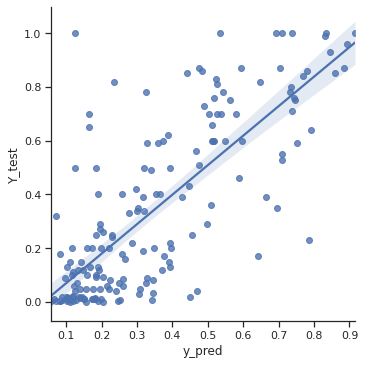

2
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
176
2-fold :  54.54545454545454
3-fold :  66.47727272727273
5-fold :  75.56818181818183
gmfe :  3.1470198769546522
mfe :  1.2962655639860963
bias :  0.04285242845436391
rmse  0.2321232521140599
r2  0.6048943076687956


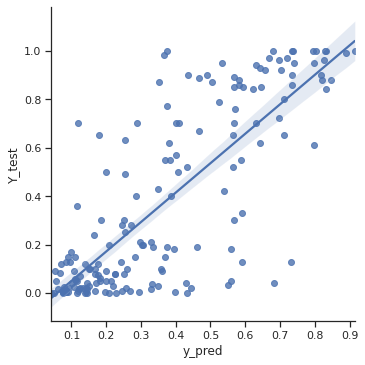

3
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  52.84090909090909
3-fold :  67.04545454545455
5-fold :  76.70454545454545
gmfe :  3.071638298211058
mfe :  1.329911758206489
bias :  0.038403505916098
rmse  0.2507507353070849
r2  0.5043254072068135


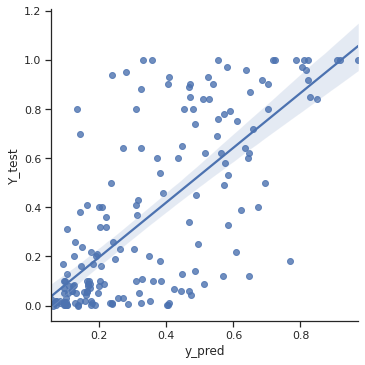

4
(704, 352)
(175, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
175
2-fold :  55.42857142857143
3-fold :  69.14285714285714
5-fold :  82.28571428571428
gmfe :  2.4823486732349953
mfe :  1.2839598190437167
bias :  0.04042130715732062
rmse  0.19001973098793687
r2  0.6311585019596317
saving model


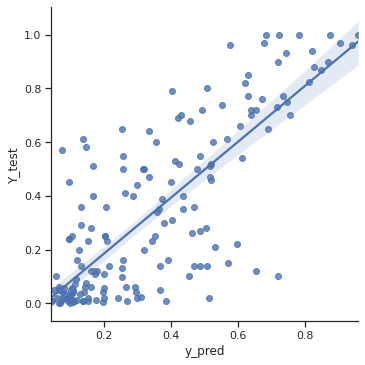

0
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
176
2-fold :  56.25
3-fold :  69.31818181818183
5-fold :  81.81818181818183
gmfe :  2.509823420887721
mfe :  1.2946108486374
bias :  0.047427614231875956
rmse  0.21015101865071603
r2  0.637787383783432


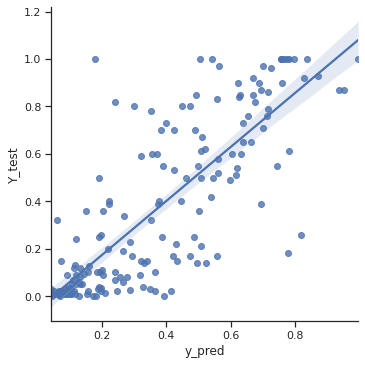

1
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
176
2-fold :  52.84090909090909
3-fold :  60.79545454545454
5-fold :  76.13636363636364
gmfe :  2.925672112862259
mfe :  1.2913313366704506
bias :  0.03082945547444084
rmse  0.2233070120099323
r2  0.5436745021730622


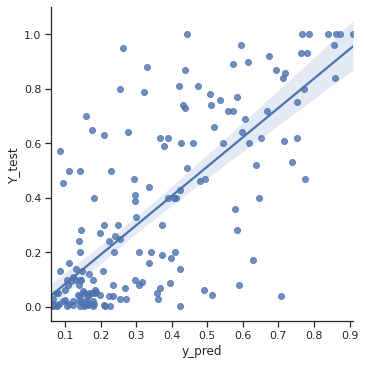

2
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
176
2-fold :  57.38636363636363
3-fold :  67.61363636363636
5-fold :  76.13636363636364
gmfe :  2.9778965417120054
mfe :  1.281794646545678
bias :  0.036167147858160775
rmse  0.20863415078047987
r2  0.6212073009026032


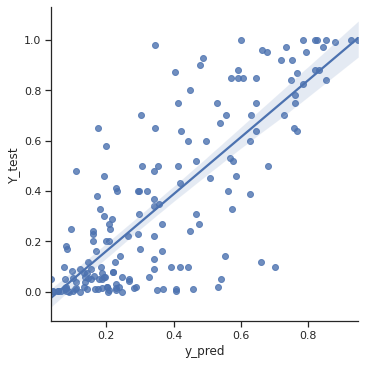

3
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
176
2-fold :  53.40909090909091
3-fold :  66.47727272727273
5-fold :  79.54545454545455
gmfe :  2.9041864446839303
mfe :  1.2730912094253055
bias :  0.03586826345299121
rmse  0.22256074124553712
r2  0.6007826453433199


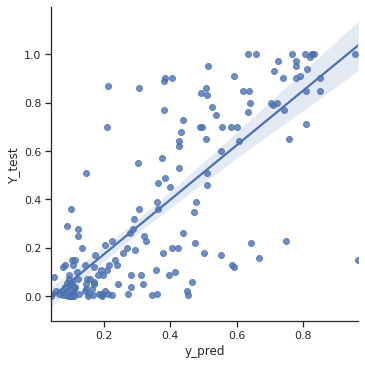

4
(704, 352)
(175, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
175
2-fold :  50.857142857142854
3-fold :  61.71428571428571
5-fold :  76.0
gmfe :  2.8366071161462956
mfe :  1.325565507087542
bias :  0.05361885953140804
rmse  0.21959231742128227
r2  0.5573249837590937


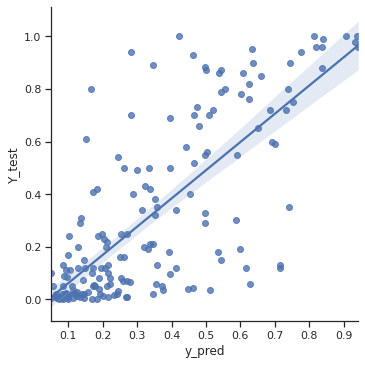

0
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
176
2-fold :  45.45454545454545
3-fold :  61.36363636363637
5-fold :  75.0
gmfe :  3.358483550878706
mfe :  1.4117608733902023
bias :  0.06880354443078286
rmse  0.23157677514686023
r2  0.4268571589790555


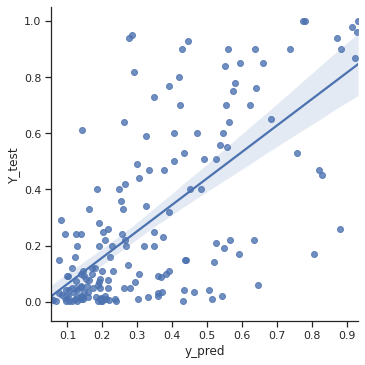

1
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
176
2-fold :  55.11363636363637
3-fold :  66.47727272727273
5-fold :  78.97727272727273
gmfe :  2.7280493496841096
mfe :  1.3061708837997281
bias :  0.029843892591351426
rmse  0.2404906850301663
r2  0.5002137567879554


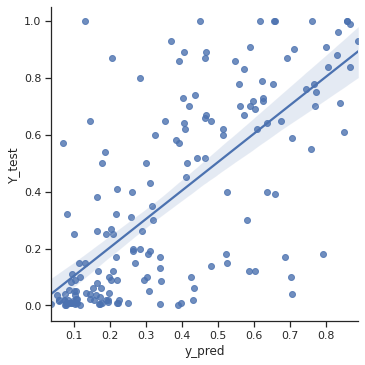

2
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
176
2-fold :  56.81818181818182
3-fold :  69.88636363636364
5-fold :  77.27272727272727
gmfe :  2.7472566745212506
mfe :  1.29343480899801
bias :  0.013928361034764247
rmse  0.21716128819818872
r2  0.6270735462168902


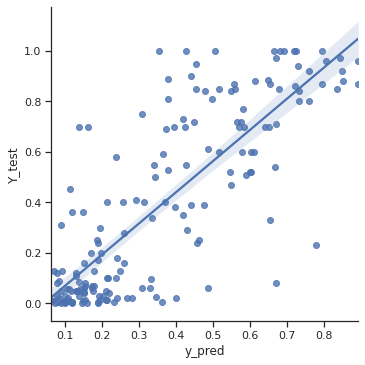

3
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=45)
176
2-fold :  58.52272727272727
3-fold :  68.18181818181817
5-fold :  76.70454545454545
gmfe :  2.700207580549309
mfe :  1.2593439569439167
bias :  0.05071141851568977
rmse  0.20835825465065083
r2  0.6182595900879835


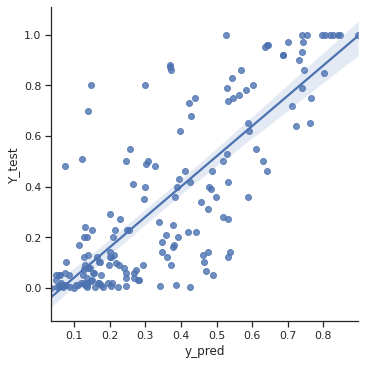

4
(704, 352)
(175, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
175
2-fold :  58.285714285714285
3-fold :  71.42857142857143
5-fold :  78.85714285714286
gmfe :  2.7621249321101775
mfe :  1.246055024796294
bias :  0.03520165705309666
rmse  0.20620638776518127
r2  0.6581751427238828


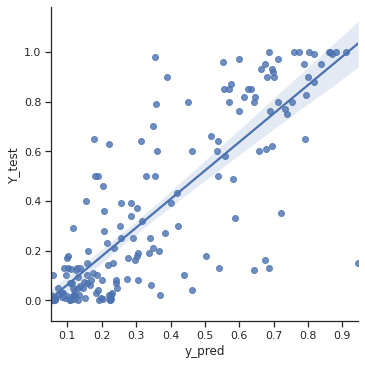

0
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
176
2-fold :  52.27272727272727
3-fold :  63.06818181818182
5-fold :  76.13636363636364
gmfe :  3.091288659660106
mfe :  1.3028076342997268
bias :  0.0557610153599085
rmse  0.23146095436672073
r2  0.5620696126016349


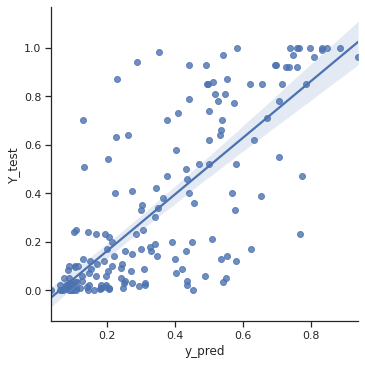

1
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
176
2-fold :  57.38636363636363
3-fold :  69.31818181818183
5-fold :  80.68181818181817
gmfe :  2.7014692535269114
mfe :  1.2510618478253492
bias :  0.022698160622583
rmse  0.20902134437083758
r2  0.603471822953749


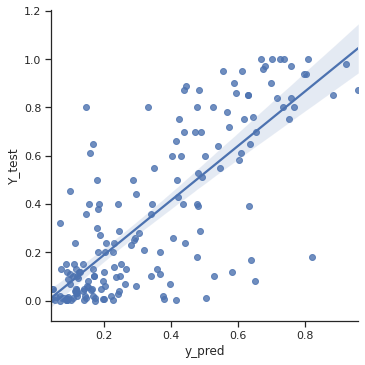

2
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  51.13636363636363
3-fold :  61.93181818181818
5-fold :  78.4090909090909
gmfe :  2.8090143666120526
mfe :  1.3170123161420586
bias :  0.05187638943123458
rmse  0.22389524491105614
r2  0.5816860477273202


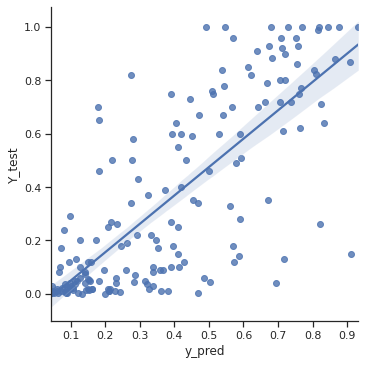

3
(703, 352)
(176, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  60.22727272727273
3-fold :  73.29545454545455
5-fold :  78.97727272727273
gmfe :  2.726225409905983
mfe :  1.2400496622243684
bias :  0.02957961325753699
rmse  0.19533840274809858
r2  0.6466509697075858


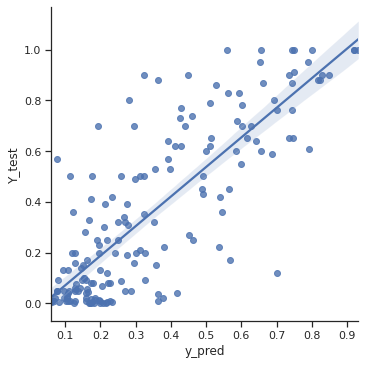

4
(704, 352)
(175, 352)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
175
2-fold :  52.0
3-fold :  65.71428571428571
5-fold :  76.57142857142857
gmfe :  2.727240300579706
mfe :  1.2749613166199771
bias :  0.03740727979382444
rmse  0.22126718876984933
r2  0.5925482206943447


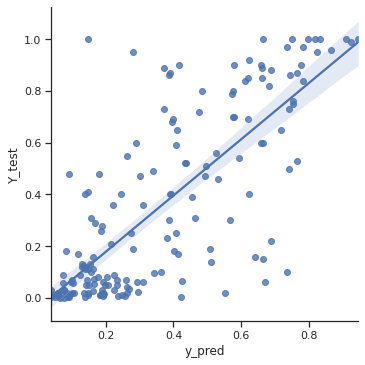

human_mrt
0
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
249
2-fold :  45.78313253012048
3-fold :  69.47791164658635
5-fold :  82.32931726907631
gmfe :  2.582446674780924
mfe :  1.399643229780893
bias :  0.1535549001522556
rmse  0.5446196115347645
r2  0.22911300234490117
saving model


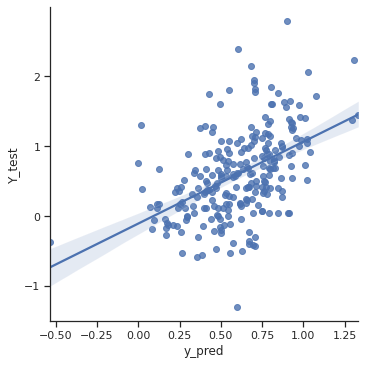

1
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
249
2-fold :  48.19277108433735
3-fold :  71.8875502008032
5-fold :  85.94377510040161
gmfe :  2.4899992803770146
mfe :  1.3641687948902756
bias :  -0.3198302863901459
rmse  0.532511553118282
r2  0.21898946723233625
saving model


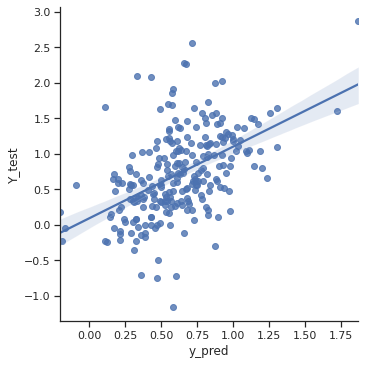

2
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
249
2-fold :  52.208835341365464
3-fold :  72.28915662650603
5-fold :  82.73092369477911
gmfe :  2.5618162011533583
mfe :  1.346008945387298
bias :  -0.08104179353329144
rmse  0.5648130495447736
r2  0.2716518309011734


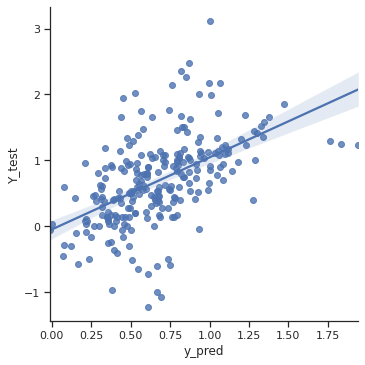

3
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
248
2-fold :  52.016129032258064
3-fold :  70.56451612903226
5-fold :  83.06451612903226
gmfe :  2.57543027980363
mfe :  1.3283319349836147
bias :  -0.06750348875141166
rmse  0.5879790569017074
r2  0.2793907463896569


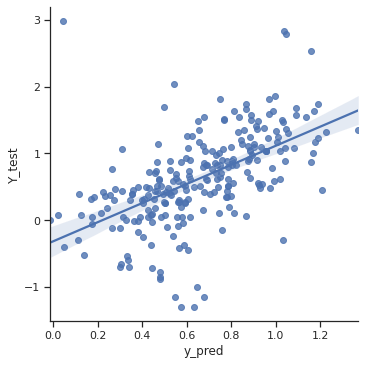

4
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=42)
248
2-fold :  50.403225806451616
3-fold :  67.33870967741935
5-fold :  80.24193548387096
gmfe :  2.5242953444551075
mfe :  1.3501169221274938
bias :  0.5072188417409804
rmse  0.5393357968618757
r2  0.23465728366271288


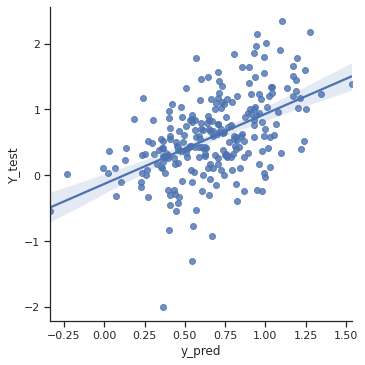

0
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
249
2-fold :  47.791164658634536
3-fold :  71.4859437751004
5-fold :  84.73895582329317
gmfe :  2.5401550150871666
mfe :  1.3641483291998882
bias :  -0.14426342500359457
rmse  0.5530178246135327
r2  0.25747416420807734


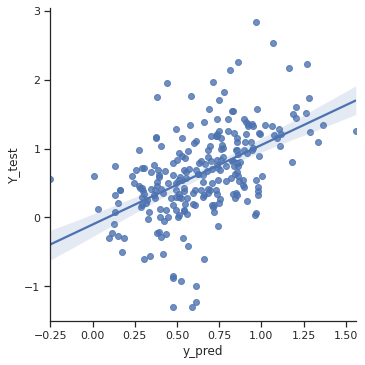

1
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=43)
249
2-fold :  46.58634538152611
3-fold :  65.46184738955823
5-fold :  80.72289156626506
gmfe :  2.737263248540864
mfe :  1.3760434550545129
bias :  0.040339556770636165
rmse  0.5946241515943075
r2  0.266871855936363


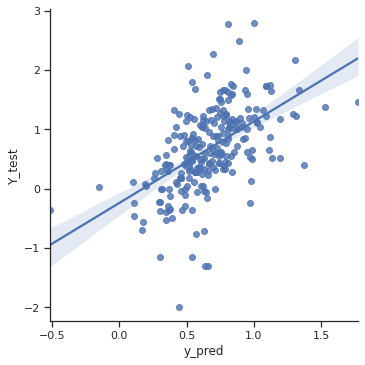

2
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  47.791164658634536
3-fold :  67.06827309236948
5-fold :  84.73895582329317
gmfe :  2.5041416622652304
mfe :  1.36257940086205
bias :  0.0794508099091118
rmse  0.5255723185544349
r2  0.2634354318728461


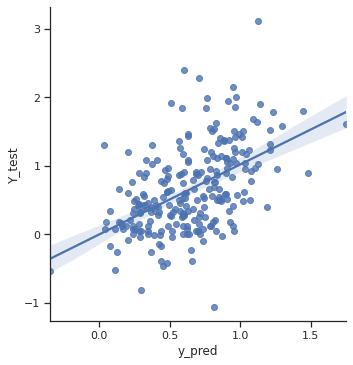

3
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
248
2-fold :  50.806451612903224
3-fold :  69.35483870967742
5-fold :  81.45161290322581
gmfe :  2.6136121484299935
mfe :  1.3385183092091233
bias :  0.10746617441263712
rmse  0.5791468831049492
r2  0.22755948704368056


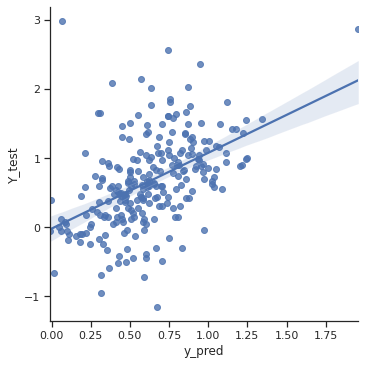

4
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=43)
248
2-fold :  53.2258064516129
3-fold :  74.59677419354838
5-fold :  86.29032258064517
gmfe :  2.292701833295432
mfe :  1.320101207179727
bias :  0.32195529082577384
rmse  0.48277152064917017
r2  0.3381563804868435
saving model


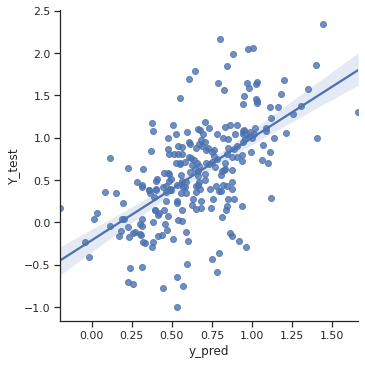

0
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  48.59437751004016
3-fold :  70.68273092369478
5-fold :  85.54216867469879
gmfe :  2.404187964102466
mfe :  1.3620996156028586
bias :  -0.16137717895267834
rmse  0.5052253481236519
r2  0.27476307515952425


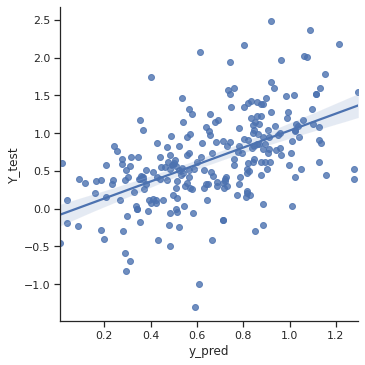

1
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
249
2-fold :  52.208835341365464
3-fold :  70.28112449799197
5-fold :  81.92771084337349
gmfe :  2.628057403286573
mfe :  1.3110028430470844
bias :  0.29749867731674096
rmse  0.5981270177321586
r2  0.25358207369693797


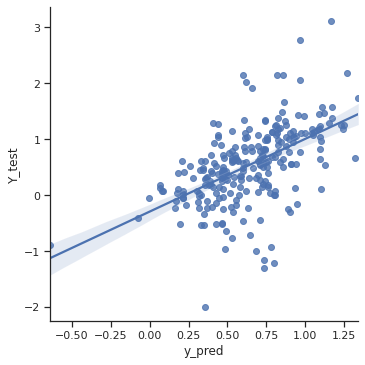

2
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  46.1847389558233
3-fold :  70.28112449799197
5-fold :  82.32931726907631
gmfe :  2.4872765238976746
mfe :  1.383507524514775
bias :  -0.0006083527432602931
rmse  0.5271005318191279
r2  0.28279487751932375


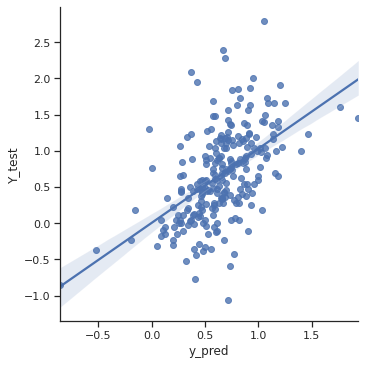

3
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
248
2-fold :  50.806451612903224
3-fold :  70.56451612903226
5-fold :  80.64516129032258
gmfe :  2.5699103246057398
mfe :  1.344870810577117
bias :  0.19448889999945318
rmse  0.5511487201144125
r2  0.2242840499378317


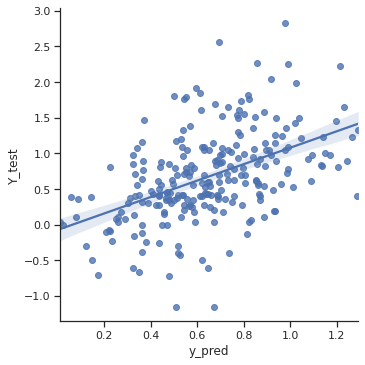

4
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
248
2-fold :  45.16129032258064
3-fold :  70.56451612903226
5-fold :  83.87096774193549
gmfe :  2.5387622134092447
mfe :  1.385849737283002
bias :  -0.22662545630439623
rmse  0.549981426080476
r2  0.30446943989324704


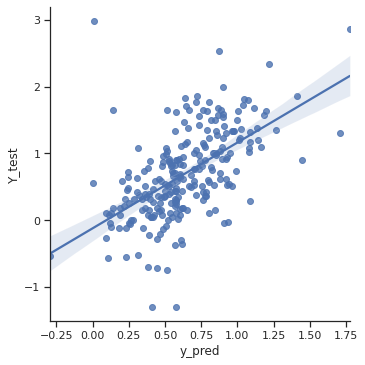

0
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=45)
249
2-fold :  47.389558232931726
3-fold :  70.28112449799197
5-fold :  83.13253012048193
gmfe :  2.538112487253924
mfe :  1.3782668809189855
bias :  -0.5171544053356052
rmse  0.5524049194812024
r2  0.24012312254474866


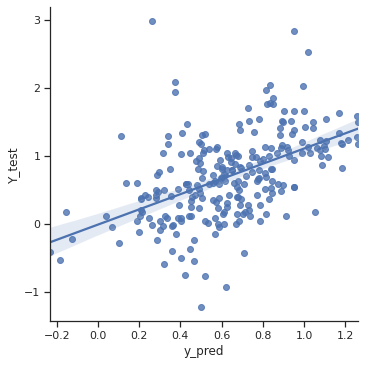

1
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
249
2-fold :  47.791164658634536
3-fold :  67.8714859437751
5-fold :  81.12449799196787
gmfe :  2.7490138203582237
mfe :  1.3764456028719454
bias :  0.29022584440968036
rmse  0.6036873846242735
r2  0.25396865734741114


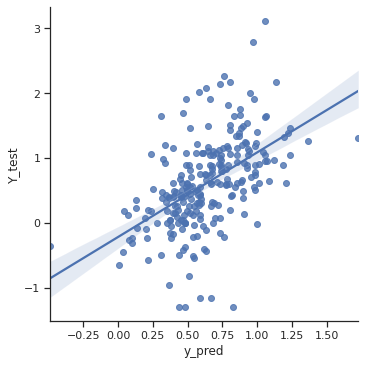

2
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
249
2-fold :  51.00401606425703
3-fold :  73.89558232931726
5-fold :  85.14056224899599
gmfe :  2.445049773327268
mfe :  1.3442161684544052
bias :  -0.16836155494136662
rmse  0.5324779242962927
r2  0.2965329949040607


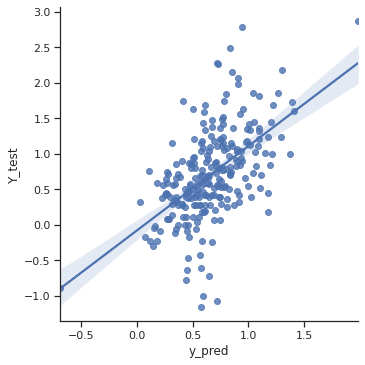

3
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
248
2-fold :  50.0
3-fold :  72.98387096774194
5-fold :  84.2741935483871
gmfe :  2.372618566801006
mfe :  1.3486271866951869
bias :  0.05491860035189089
rmse  0.4947436150808242
r2  0.3263347796552204


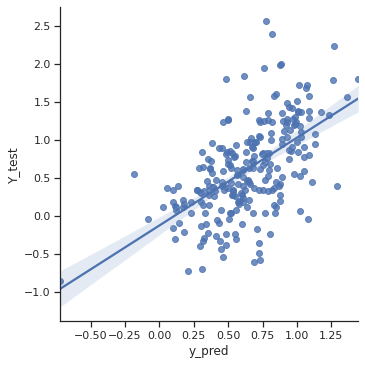

4
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
248
2-fold :  50.0
3-fold :  67.74193548387096
5-fold :  82.66129032258065
gmfe :  2.50258313328176
mfe :  1.345783001217137
bias :  0.5781614843617042
rmse  0.5388241675083735
r2  0.2550991087475357


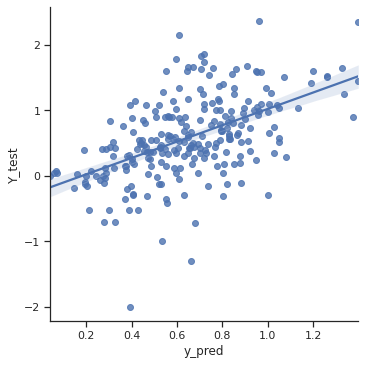

0
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
249
2-fold :  47.791164658634536
3-fold :  68.67469879518072
5-fold :  81.12449799196787
gmfe :  2.6691648038656353
mfe :  1.3821268356111653
bias :  0.22525196092611388
rmse  0.5668545716434578
r2  0.2882181618044255


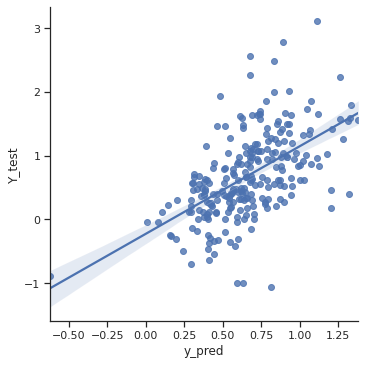

1
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=46)
249
2-fold :  52.610441767068274
3-fold :  72.28915662650603
5-fold :  84.33734939759037
gmfe :  2.4000561396784765
mfe :  1.3316976834253862
bias :  -0.012867282958310966
rmse  0.5165028111689778
r2  0.3136351639741053


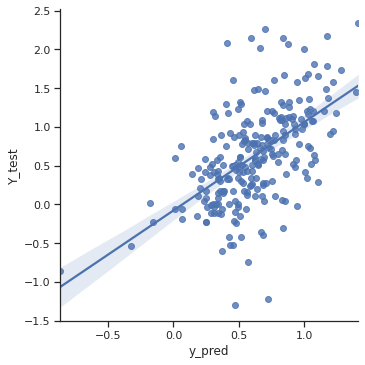

2
(994, 352)
(249, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
249
2-fold :  54.61847389558233
3-fold :  73.89558232931726
5-fold :  85.94377510040161
gmfe :  2.303883896795206
mfe :  1.3124629528090683
bias :  -0.026087944370463134
rmse  0.4974770817437786
r2  0.3328458753048398


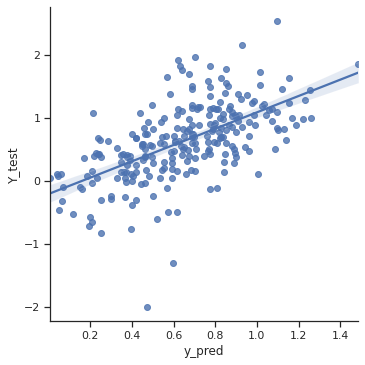

3
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
248
2-fold :  44.75806451612903
3-fold :  65.32258064516128
5-fold :  79.03225806451613
gmfe :  2.8879792085497185
mfe :  1.4185955288013818
bias :  -0.041534722421520565
rmse  0.6373869455900246
r2  0.13579514649803137


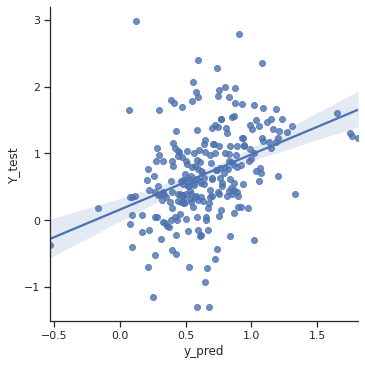

4
(995, 352)
(248, 352)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
248
2-fold :  46.37096774193548
3-fold :  72.58064516129032
5-fold :  85.48387096774194
gmfe :  2.423857333402345
mfe :  1.3780634721615543
bias :  0.5358095382929366
rmse  0.5098862924016028
r2  0.29355440440822633


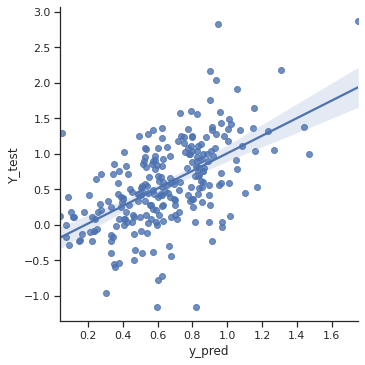

human_thalf
0
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  46.6403162055336
3-fold :  69.56521739130434
5-fold :  84.58498023715416
gmfe :  2.522675205622583
mfe :  1.3976013362362514
bias :  -0.11905323418726566
rmse  0.522899686740772
r2  0.30593169150615807
saving model


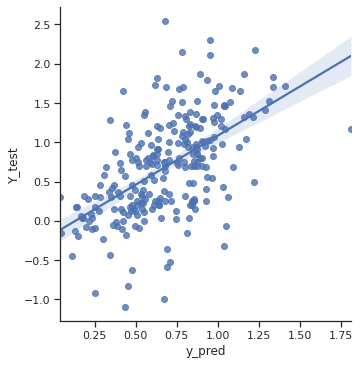

1
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
253
2-fold :  52.96442687747036
3-fold :  69.1699604743083
5-fold :  83.79446640316206
gmfe :  2.4717770725310415
mfe :  1.3292157046880675
bias :  0.4486027897795446
rmse  0.529623192666409
r2  0.27421846331296207
saving model


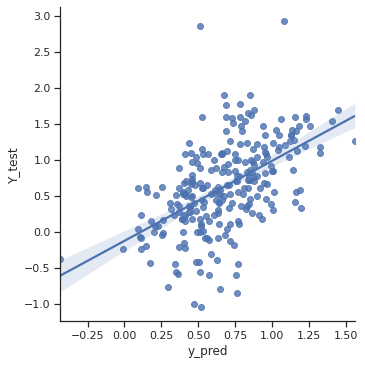

2
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=42)
253
2-fold :  54.1501976284585
3-fold :  73.51778656126481
5-fold :  86.16600790513834
gmfe :  2.379033201915214
mfe :  1.3228331443657042
bias :  0.07886902180082078
rmse  0.4953684581790774
r2  0.2790094232834206
saving model


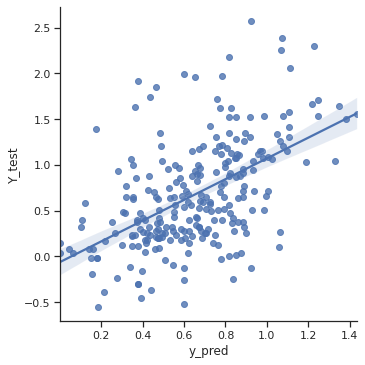

3
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
253
2-fold :  50.59288537549407
3-fold :  67.58893280632411
5-fold :  81.81818181818183
gmfe :  2.7539524728293028
mfe :  1.3488769829851777
bias :  0.4405896974072636
rmse  0.6061121259641091
r2  0.2488194125530574


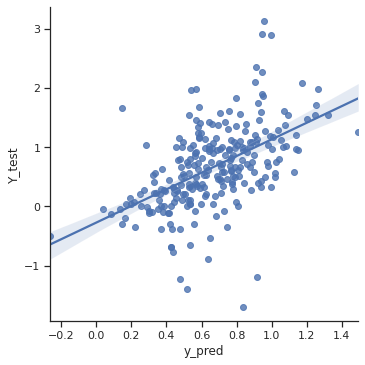

4
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
253
2-fold :  52.569169960474305
3-fold :  75.8893280632411
5-fold :  89.32806324110672
gmfe :  2.196984819306056
mfe :  1.3220958046876536
bias :  0.19240075324025563
rmse  0.4585079978006594
r2  0.358552058519212
saving model


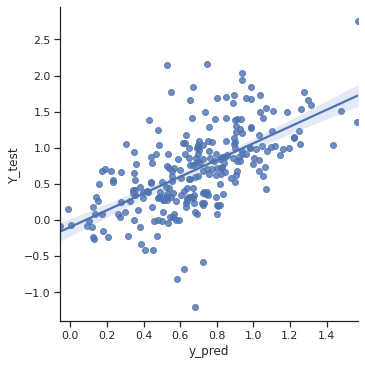

0
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  45.8498023715415
3-fold :  71.93675889328063
5-fold :  89.32806324110672
gmfe :  2.2992373376294135
mfe :  1.3771285870135952
bias :  0.015904432013226888
rmse  0.46278883436049356
r2  0.32674009700921236


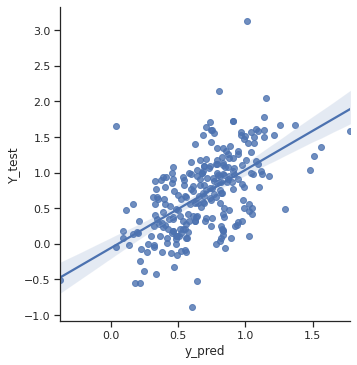

1
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  50.59288537549407
3-fold :  68.37944664031622
5-fold :  81.81818181818183
gmfe :  2.5997680397723912
mfe :  1.349333387826969
bias :  0.6627003221043521
rmse  0.570390187242719
r2  0.26860524463418356


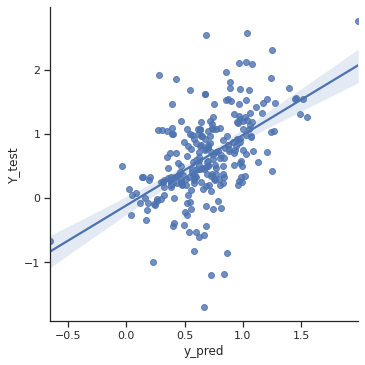

2
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
253
2-fold :  52.569169960474305
3-fold :  69.1699604743083
5-fold :  86.16600790513834
gmfe :  2.453349575111817
mfe :  1.3285627073843445
bias :  0.10191083391242595
rmse  0.5254423130688921
r2  0.2521069070804356


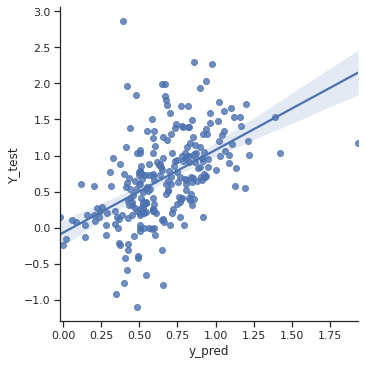

3
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
253
2-fold :  48.22134387351779
3-fold :  71.14624505928853
5-fold :  86.16600790513834
gmfe :  2.4594435985048295
mfe :  1.3688376265876343
bias :  0.12896849740530758
rmse  0.5114938001987782
r2  0.31735201243259326


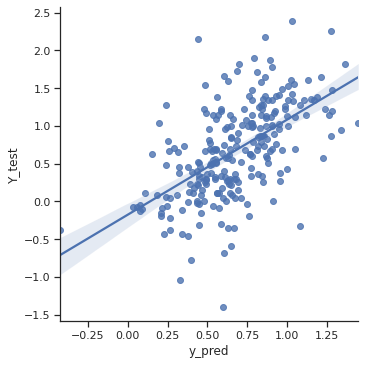

4
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  50.19762845849802
3-fold :  72.33201581027669
5-fold :  85.7707509881423
gmfe :  2.4449433869748485
mfe :  1.3477192227924693
bias :  0.2897226036624956
rmse  0.5330566786478852
r2  0.3290305183396379


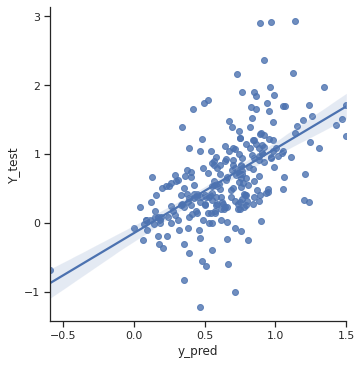

0
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=44)
253
2-fold :  52.569169960474305
3-fold :  77.07509881422925
5-fold :  88.53754940711462
gmfe :  2.268229608000318
mfe :  1.3441928295397274
bias :  0.18641800788552132
rmse  0.4662210890717156
r2  0.32831588160394143


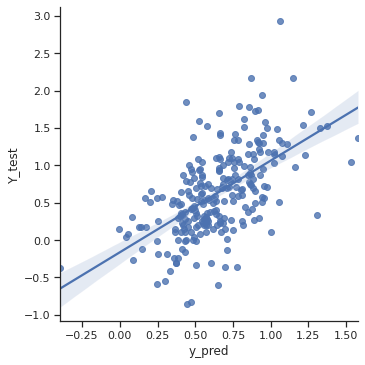

1
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
253
2-fold :  49.80237154150198
3-fold :  68.37944664031622
5-fold :  83.79446640316206
gmfe :  2.523226662488536
mfe :  1.3555653387631459
bias :  0.06128052996402733
rmse  0.5390278772297323
r2  0.30918369470271756


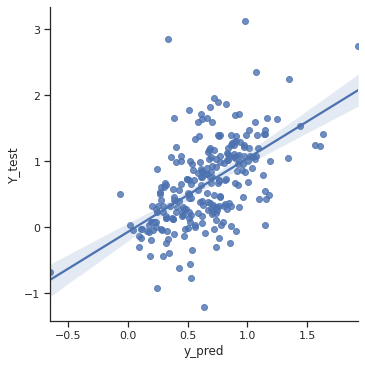

2
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
253
2-fold :  50.988142292490124
3-fold :  70.7509881422925
5-fold :  88.93280632411067
gmfe :  2.403384294207582
mfe :  1.3337344858370288
bias :  0.17859246226116032
rmse  0.5038361102053605
r2  0.2940584764088441


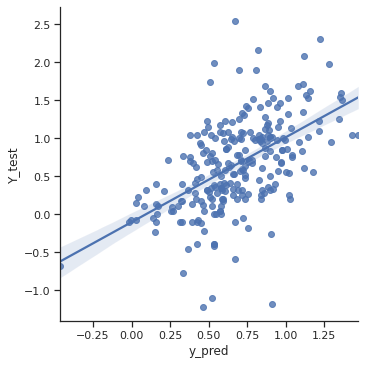

3
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
253
2-fold :  48.22134387351779
3-fold :  65.61264822134387
5-fold :  82.21343873517787
gmfe :  2.663049764494823
mfe :  1.3630033232422312
bias :  0.6772010344185375
rmse  0.5696152933296663
r2  0.25521981852829323


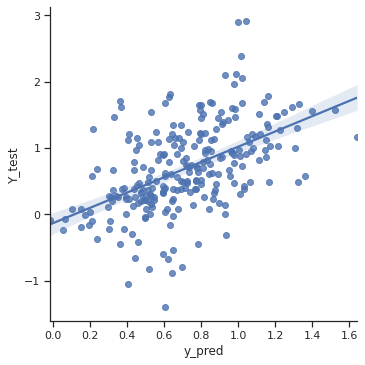

4
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
253
2-fold :  46.6403162055336
3-fold :  71.14624505928853
5-fold :  84.18972332015811
gmfe :  2.537825235478098
mfe :  1.3711768685569827
bias :  -0.02242967344817437
rmse  0.5543284924353352
r2  0.2276410604906719


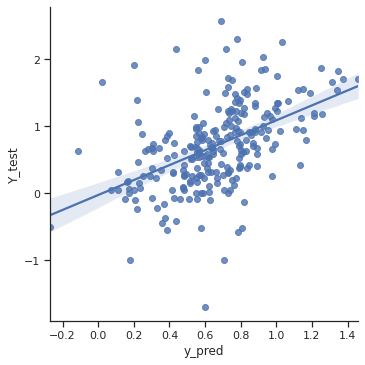

0
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  44.66403162055336
3-fold :  70.35573122529645
5-fold :  86.16600790513834
gmfe :  2.561810431824082
mfe :  1.3890379815893943
bias :  0.4080197500659939
rmse  0.5426460372928462
r2  0.24637272954984135


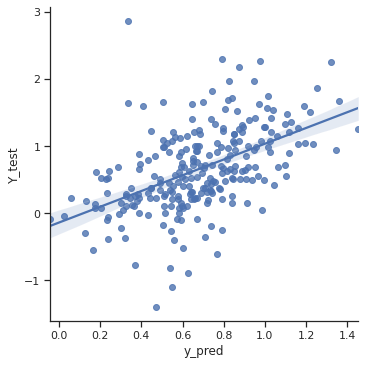

1
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  52.569169960474305
3-fold :  72.33201581027669
5-fold :  88.14229249011858
gmfe :  2.310846546859596
mfe :  1.327720979001695
bias :  0.24980637333160605
rmse  0.47017136704568785
r2  0.321582673930757


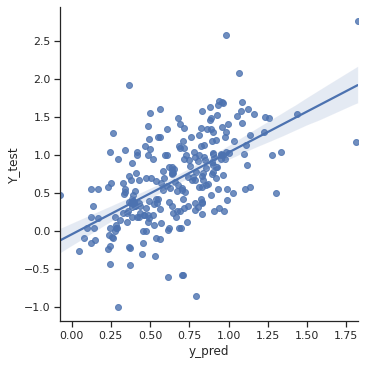

2
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  52.17391304347826
3-fold :  71.93675889328063
5-fold :  84.58498023715416
gmfe :  2.4590260717316146
mfe :  1.3327827590920978
bias :  -0.30472627634334515
rmse  0.5486774706245972
r2  0.27264622197632404


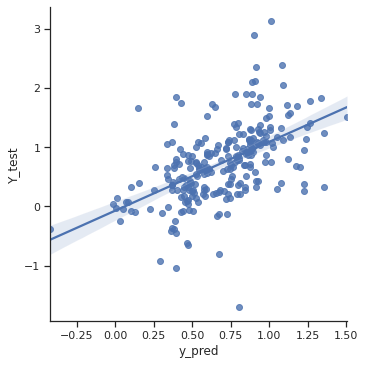

3
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  49.01185770750988
3-fold :  69.56521739130434
5-fold :  83.00395256916995
gmfe :  2.579448188309235
mfe :  1.3629250551487646
bias :  0.39412650815589245
rmse  0.5506343221641986
r2  0.2785190720036629


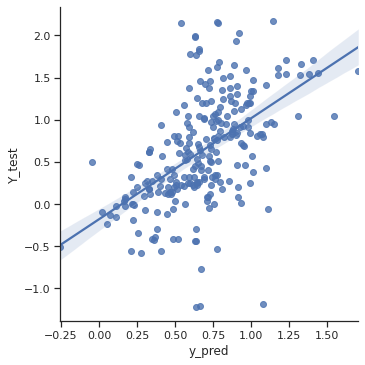

4
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=45)
253
2-fold :  49.01185770750988
3-fold :  72.33201581027669
5-fold :  85.7707509881423
gmfe :  2.3885222164979063
mfe :  1.3567170746835102
bias :  0.2124044812663357
rmse  0.5046164237035039
r2  0.34041316438446956


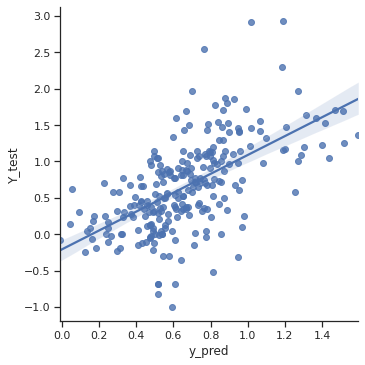

0
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
253
2-fold :  45.8498023715415
3-fold :  66.40316205533597
5-fold :  84.58498023715416
gmfe :  2.6008442386146693
mfe :  1.3971485938059591
bias :  -0.19181243376365043
rmse  0.5509271715425271
r2  0.20323225234112618


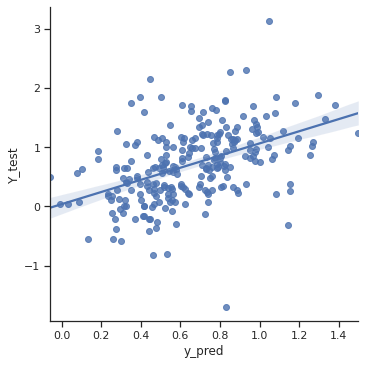

1
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
253
2-fold :  50.988142292490124
3-fold :  75.09881422924902
5-fold :  89.32806324110672
gmfe :  2.2778572115986058
mfe :  1.3460722250825607
bias :  0.25604835574785856
rmse  0.46979763702497535
r2  0.31443260093006276


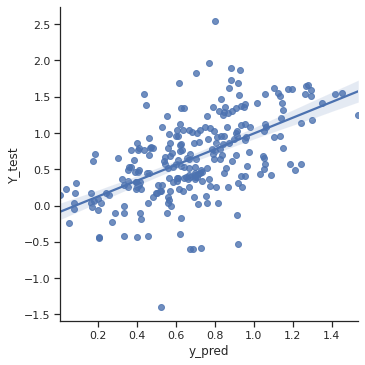

2
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
253
2-fold :  47.82608695652174
3-fold :  71.93675889328063
5-fold :  83.79446640316206
gmfe :  2.4475580934953243
mfe :  1.3679572396877862
bias :  0.251483208528831
rmse  0.5186135018634007
r2  0.26740919196420043


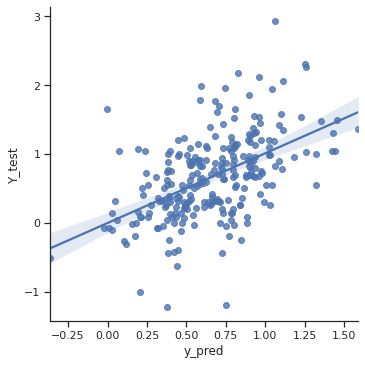

3
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
253
2-fold :  47.03557312252965
3-fold :  68.37944664031622
5-fold :  84.18972332015811
gmfe :  2.6198126997700073
mfe :  1.3658289398549506
bias :  0.19933061607921276
rmse  0.5616832580535712
r2  0.3209624062440084


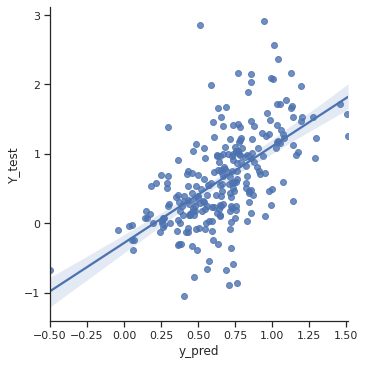

4
(1012, 352)
(253, 352)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  50.59288537549407
3-fold :  71.54150197628458
5-fold :  87.35177865612648
gmfe :  2.4033114847488104
mfe :  1.3313680800503025
bias :  0.1454625815646895
rmse  0.5152818011039386
r2  0.3429830877483534


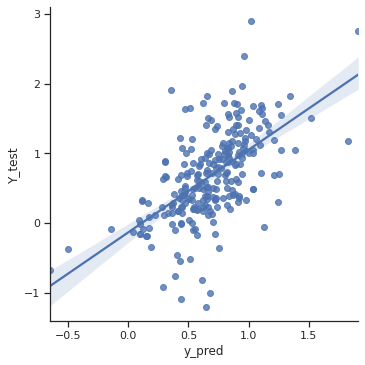

In [27]:
from sklearn.preprocessing import StandardScaler
import pickle

list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    #log human_VDss_L_kg model
    data = human_lombardo_Mordred
    features = features_mordred_columns
    baseline=10

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features) 
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_mrd_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])

In [28]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           300         sqrt   
1    human_VDss_L_kg            42      1           300         sqrt   
2    human_VDss_L_kg            42      2           300         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           200         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           200         sqrt   
121      human_thalf            46      1           300         log2   
122      human_thalf            46      2           200         sqrt   
123      human_thalf            46      3           300         sqrt   
124      human_thalf            46      4           300         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    2         15      False  
1                    4         15      False  
2                    2         15      False  
3                    8         15      False  
4                    2         15      False  
..                 ...        ...        ...  
120                  4         15      False  
121                  4         15      False  
122                  2         15      False  
123                  8         15      False  
124                  2         15      False  

[125 rows x 8 columns]

In [29]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                            "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.236090  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.035033 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.705762 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.354927  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...  0.063934  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.871959  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.521918  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.571384 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.530311  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.917535  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [30]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  54.800000  74.400000   
1    HeldOut  human_VDss_L_kg            42      1  56.800000  74.000000   
2    HeldOut  human_VDss_L_kg            42      2  56.800000  74.000000   
3    HeldOut  human_VDss_L_kg            42      3  58.400000  73.600000   
4    HeldOut  human_VDss_L_kg            42      4  53.815261  72.690763   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  45.849802  66.403162   
121  HeldOut      human_thalf            46      1  50.988142  75.098814   
122  HeldOut      human_thalf            46      2  47.826087  71.936759   
123  HeldOut      human_thalf            46      3  47.035573  68.379447   
124  HeldOut      human_thalf            46      4  50.592885  71.541502   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    87.200000  2.191733  1.299203  0.027854  0.454587  0.521052  
1    88.400000  2.113303  1.282035  0.102243  0.423209  0.520264  
2    85.600000  2.225392  1.283345  0.001303  0.478913  0.471984  
3    88.800000  2.132033  1.299592  0.004299  0.432933  0.552457  
4    88.755020  2.211027  1.298015  0.070278  0.454667  0.464208  
..         ...       ...       ...       ...       ...       ...  
120  84.584980  2.600844  1.397149 -0.191812  0.550927  0.203232  
121  89.328063  2.277857  1.346072  0.256048  0.469798  0.314433  
122  83.794466  2.447558  1.367957  0.251483  0.518614  0.267409  
123  84.189723  2.619813  1.365829  0.199331  0.561683  0.320962  
124  87.351779  2.403311  1.331368  0.145463  0.515282  0.342983  

[125 rows x 12 columns]

In [31]:
detail_list.to_csv("detail_list_Prediction_human_from_mordred_fs.csv", index=False)

In [32]:
model_parameters.to_csv("model_parameters_Prediction_human_from_mordred_fs.csv", index=False)

In [33]:
results.to_csv("Prediction_human_from_mordred_fs.csv", index=False)

In [34]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_mordred.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  49.617826  69.321133  84.293045   
human_VDss_L_kg             44.0    2.0  56.509430  74.107888  88.615647   
human_fup                   44.0    2.0  54.380000  66.508052  77.770260   
human_mrt                   44.0    2.0  49.203783  70.297448  83.152934   
human_thalf                 44.0    2.0  49.691700  70.861660  85.581028   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.527605  1.354240 -0.264108  0.548635  0.280476  
human_VDss_L_kg     2.163611  1.291069  0.037554  0.444512  0.515176  
human_fup           2.845941  1.295564  0.040323  0.218932  0.582500  
human_mrt           2.533695  1.358131  0.064763  0.547449  0.266532  
human_thalf         2.465037  1.353497  0.197673  0.523270  0.291334

In [35]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_mrd_model.sav", 'rb'))

In [36]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)